---
# NOTEBOOK 1 - EXPLORATORY DATA ANALYSIS:
## Initial Data Evaluation and Feature Exploration
---

# PROJECT : Boston Airbnb Fair Pricing Tool and Recommender

# Notebook Directory
There are six notebooks associated with this project.  A quick overview of each will be provided here:

* Notebook 1 - Exploratory Data Analysis.  Creates train, test, validation datasets, and performs simple EDA on numerical and categorical variables.  This excludes EDA on columns which require advanced preprocessing and feature engineering
* Notebook 2 - Feature Engineering Part 1.  Examines the features excluded from EDA and extracts or creates new features
* Notebook 3 - Feature Engineering Part 2.  Creates a feature loosely representing the distance from each listing to the nearest public transit (subway) stop obtaining additional data from the web
* Notebook 4 - Data Preprocessor and Compiler - Creates functions which perform all necessary transformation steps (previously performed in Notebooks 1, 2 and 3) to all datasets
* Notebook 5 - Modeling - Selects features based on correlation and creates price prediction models
* Notebook 6 - Recommender - Creates a near-prototype fair price and listing recommender tool

# Problem Statement
This report is written from the standpoint of an entrepreneur (Data Scientist and founder of Cheap Stays, LLC) looking to create a digital product which will help users quickly identify the fair price for an Airbnb which matches their desired criteria. It will also recommend Airbnb listings which match their criteria.

Airbnb is a popular website for those who travel for business or pleasure and need lodging but choose not to go the traditional hotel-route.  Usually, hosts offer-up their personal or secondary properties for people to stay at for a fee.  This fee may be cheaper than hotels while also providing the comforts of a furnished home depending on the type of listing.  Some individuals (hosts) will offer their dwellings as a source of passive income, and others have made Airbnb their main income stream.  Potential guests would likely find it beneficial to understand what constitutes a 'fair' price for an Airbnb given a set of desired criteria.  They would further be interested in seeing listings matching their input criteria at the same time.  Potential hosts may be looking to understand the current market for Airbnb listings similar to their own and would benefit from a pricing tool and similar listing recommender.

This project will seek to determine if an accurate fair-pricing tool can be developed to predict the prices of Airbnb listings in the Boston area while providing suggestions for currently listed Airbnb’s.  The accuracy of the pricing tool will be evaluated by the root mean squared error, and the target error will be approximately equal to $20 given that most Airbnb listings are listed in the low hundreds of dollars.

# Data Sources
* "Inside Airbnb" is a database which regularly collects Airbnb listing data for multiple cities around the world.  The website can be accessed [here](http://insideairbnb.com/get-the-data/) by scrolling down to where Boston is listed
* The actual data was downloaded in the Boston section by clicking the '[listings.csv.gz](http://data.insideairbnb.com/united-states/ma/boston/2023-03-19/data/listings.csv.gz)' link
* The data dictionary can be accessed from the main webpage above and is located [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596)

The data were downloaded on 2023-05-30 and are from the most recent scraping dated 2023-03-19 on the Inside Airbnb website


Other data are sourced in Notebook 3 from the Massachusetts Bay Transit Authority (MBTA) Website and the Google Geocoding API.  Those sources will be discussed in greater detail in that notebook.

# NOTE REGARDING DATASETS CREATED FOR THIS PROJECT
Three datasets are created from the data downloaded from Inside Airbnb and include training, validation, and testing datasets, but only two of them are used.

The project in its current state will ONLY utilize the training and validation datasets.  The intention in creating three datasets was to:
* Use the training dataset to train the models
* Use the validation data to both evaluate the model(s) performance and inform optimization or possible feature creation
* Use the testing dataset to act as unseen data which can then evaluate the model or models optimized against the validation dataset

The point of doing all of this was to avoid data leakage while also allowing some new data (the validation set) to help refine the model.

Given the performance of the models created and the extensive amount of work done to engineer and select features, the models were not able to be significantly refined based on performance on the validation dataset.  

#### As a result of this, the testing dataset was created but never used, and the validation dataset serves the purpose that a testing dataset would.  The reason that the datasets have not been recombined into only training and test datasets is to maintain the three-dataset framework for future iterations of and refinements to this project.

# 1 - Library Imports, Read Data, and Perform Train, Valdiation, Test Splits

In [1]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For times:
import time

# Set a random seed for imputation
#  Source:  https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html
np.random.seed(42)

# Sklearn
from sklearn.model_selection import train_test_split

## 1.1 - Read Data and Examine Dataframe

In [2]:
# Import all of the listings data
listings = pd.read_csv('../data/listings.csv')
listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3781,https://www.airbnb.com/rooms/3781,20230319180919,2023-03-19,city scrape,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,"Mostly quiet ( no loud music, no crowed sidewa...",https://a0.muscache.com/pictures/24670/b2de044...,4804,...,4.96,4.88,4.92,NaN,f,1,1,0,0,0.26
1,5506,https://www.airbnb.com/rooms/5506,20230319180919,2023-03-19,city scrape,** Fort Hill Inn Private! Minutes to center!**,"Private guest room with private bath, You do n...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/miso/Hosting-...,8229,...,4.88,4.53,4.74,Approved by the government,f,10,10,0,0,0.69
2,6695,https://www.airbnb.com/rooms/6695,20230319180919,2023-03-19,city scrape,"Fort Hill Inn *Sunny* 1 bedroom, condo duplex","Comfortable, Fully Equipped private apartment...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,...,4.96,4.50,4.72,STR446650,f,10,10,0,0,0.74
3,8789,https://www.airbnb.com/rooms/8789,20230319180919,2023-03-20,city scrape,Curved Glass Studio/1bd facing Park,This unit is for sale. There will need to be o...,Beacon Hill is a historic neighborhood filled ...,https://a0.muscache.com/pictures/miso/Hosting-...,26988,...,4.96,4.96,4.56,NaN,f,7,7,0,0,0.24
4,4765070,https://www.airbnb.com/rooms/4765070,20230319180919,2023-03-19,city scrape,Studio w/ private entrance and bathroom,Private Studio located in Boston (town of Jama...,"Jamaica Plain (JP) is an open, artsy, hip neig...",https://a0.muscache.com/pictures/miso/Hosting-...,24584716,...,4.85,4.48,4.69,str-416042,t,1,1,0,0,3.77


In [3]:
# Check the features and data types with .info()
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3864 entries, 0 to 3863
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3864 non-null   int64  
 1   listing_url                                   3864 non-null   object 
 2   scrape_id                                     3864 non-null   int64  
 3   last_scraped                                  3864 non-null   object 
 4   source                                        3864 non-null   object 
 5   name                                          3864 non-null   object 
 6   description                                   3846 non-null   object 
 7   neighborhood_overview                         2497 non-null   object 
 8   picture_url                                   3864 non-null   object 
 9   host_id                                       3864 non-null   i

In [4]:
# Check for null values and sort only the columns with nulls in descnding order
pd.DataFrame(listings.isnull().sum().sort_values(ascending=False))[listings.isnull().sum() >0]

C:\Users\Dan\AppData\Local\Temp\ipykernel_17612\1370809874.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.DataFrame(listings.isnull().sum().sort_values(ascending=False))[listings.isnull().sum() >0]


,0
neighbourhood_group_cleansed,3864
bathrooms,3864
calendar_updated,3864
license,1559
neighborhood_overview,1367
neighbourhood,1367
review_scores_value,1132
review_scores_location,1132
review_scores_checkin,1132
review_scores_accuracy,1131


#### OBSERVATIONS
Many columns have extensive amounts of null values and will need to be handled accordingly.

In [5]:
# Print the colums for simple copy and paste to creat lists of columns to drop
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

## 1.2 - Create Training and Validation Datasets Along with a Hold-out (Testing) Dataset to be Used Later
* Approximately ten percent of the data in the provided dataset will be reserved
* Separate .csv files will be created for the training and testing sets
* The 'training' set will later be split into training and validation datasets
* The intent of this step is to prevent data leakage

In [6]:
# Split the data accordingly
training, testing = train_test_split(listings, test_size = 0.1, random_state = 42)

# Split the training data again to make a validation set
training, validation = train_test_split(training, test_size = 0.2, random_state = 42)

# Reset the indexes
training.reset_index(drop = True, inplace=True)
print(training.shape)

validation.reset_index(drop = True, inplace=True)
print(validation.shape)

testing.reset_index(drop = True, inplace=True)
print(testing.shape)

# Save files to .csv
training.to_csv('../data/listings_train.csv', index = False)
validation.to_csv('../data/listings_val.csv', index = False)
testing.to_csv('../data/listings_test.csv', index = False)

(2781, 75)
(696, 75)
(387, 75)


# 2 - Create EDA Functions

The functions below will handle:
* Log transformations
* Plotting histograms
* Plotting scatter plots
* Plotting scatter plots with various log transformations
* Fixing percentage data stored as objects
* Creating horizontal bar plots

In [7]:
'''
The col_logger function will need to be brough in from the other notebooks

This has been modified to include a 0 imputation value n such that transforamtion
occurs on log(n) and not log(0) which is undefined.
'''

def col_logger(data_column, zero_imp = 1):
    # Since log(0) is undefined, 0's must be treated as log(1)
    return data_column.apply(lambda x: np.log(zero_imp) if x==0 else np.log(x))

In [8]:
# Create a histogram plotting function:
def hist_plotter(data, title = None, x_lbl = None, y_lbl = 'Count',  size = (6,4), bins = None, log = False):
    plt.figure(figsize = size)
    plt.hist(data, bins = bins, log = log)
    if title == None:
        plt.title(f'{data.name}')
    else:
        plt.title(title)
    if x_lbl == None:
        plt.xlabel(f'{data.name}')
    else:
        plt.xlabel(x_lbl) 
    plt.ylabel(y_lbl)

In [9]:
# Create a function to plot one numerical column versus another
def plot_vs(data_x, data_y, title = None, x_lbl = None, y_lbl = None, size = (6,4), x_log = None, y_log = None):
    plt.figure(figsize = size)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'{data_y.name} vs. {data_x.name}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'{data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'{data_y.name}')
    else:
        plt.ylabel(y_lbl)

    if x_log != None:
        plt.xscale(x_log)
        
    if y_log != None:
        plt.yscale(y_log)

In [10]:
# Create a more advanced 'plot vs' function which examines logs too

def plot_vs_log(data_x, data_y, title = None, x_lbl = None, y_lbl = None, size = (15,4), x_log = None, y_log = None):
    
    # calculate the correlations
    #  Source for correlation:  https://www.educative.io/answers/what-is-the-statistics-correlation-method-in-python
    
    # NaNs need to be dropped, in doing that, the array dimensions must match
    #  To do that, indices will be compared to get the intersection of index values
    #  Help with this from:  https://realpython.com/numpy-scipy-pandas-correlation-python/#pearson-correlation-coefficient
    base_corr = round(pd.DataFrame([data_x, data_y]).T.corr().iloc[0][1], 3)
    y_log_corr = round(pd.DataFrame([data_x, col_logger(data_y)]).T.corr().iloc[0][1], 3)
    x_y_log_corr = round(pd.DataFrame([col_logger(data_x), col_logger(data_y)]).T.corr().iloc[0][1], 3)
    
    plt.figure(figsize = size)
    plt.subplots_adjust(wspace=0.3)
    # Untransformed variables
    plt.subplot(1, 3, 1)
    plt.scatter(data_x, data_y)
    
    # If statemt
    if title == None:
        plt.title(f'{data_y.name} \nvs. {data_x.name} \ncorr: {base_corr}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'{data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'{data_y.name}')
    else:
        plt.ylabel(y_lbl)
  
    # For log scaale, source for help:  https://www.geeksforgeeks.org/how-to-plot-logarithmic-axes-in-matplotlib/
    if x_log != None:
        plt.xscale(x_log)
        
    if y_log != None:
        plt.yscale(y_log)
    
    
    # Log transform y (adjust the axis scale)
    plt.subplot(1, 3, 2)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'Log {data_y.name} \nvs. {data_x.name}\ncorr: {y_log_corr}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'{data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'log {data_y.name}')
    else:
        plt.ylabel(y_lbl)

    if x_log != None:
        plt.xscale(x_log)
        
    plt.yscale('log')

    # Log transform BOTH x and y (adjust the axis scales)
    plt.subplot(1, 3, 3)
    plt.scatter(data_x, data_y)
    if title == None:
        plt.title(f'Log {data_y.name} \nvs. Log {data_x.name}\ncorr: {x_y_log_corr}')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'log {data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'log {data_y.name}')
    else:
        plt.ylabel(y_lbl)

    plt.xscale('log')
    plt.yscale('log')

In [11]:
# This function will attempt to convert a string percentage value into a float
#  Source for help:  https://www.w3schools.com/python/python_try_except.asp
def pcnt_floater(x):
    try:
        return float(x.replace('%', '').strip())
    except:
        return x

In [12]:
# Create a more advanced 'plot vs' function which examines logs too

def hbar_plotter_price(data_x, spc = 0.2, title = None, x_lbl = None, y_lbl = None, size = (15,4), x_log = None, y_log = None):
    
    plt.figure(figsize = size)
    
    # Space help from:  https://www.geeksforgeeks.org/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python/
    plt.subplots_adjust(wspace=spc)
    
    # Regular Count Plot
    plt.subplot(1, 2, 1)
    
    # Source to get Horizontal count plot:  https://www.geeksforgeeks.org/countplot-using-seaborn-in-python/
    sns.countplot(y = data_x)
    if title == None:
        plt.title(f'Count Plot {data_x.name}')
    else:
        plt.title(title)

    plt.xlabel('Count') 

    if y_lbl == None:
        plt.ylabel(f'{data_x.name}')
    else:
        plt.ylabel(y_lbl)

    if x_log != None:
        plt.xscale(x_log)
        
    if y_log != None:
        plt.yscale(y_log)
    
    # Create groupyby dataframe
    grpby_df = lstn[[data_x.name, 'price']].groupby(by = data_x.name).mean()
                  
                  
    # Bar plot for groupby
    plt.subplot(1, 2, 2)
    plt.barh(y = grpby_df.index, width = grpby_df.price)
    if title == None:
        plt.title(f'Avg. Price by {data_x.name} Category')
    else:
        plt.title(title)

    if x_lbl == None:
        plt.xlabel(f'{data_x.name}')
    else:
        plt.xlabel(x_lbl) 

    if y_lbl == None:
        plt.ylabel(f'{data_x.name}')
    else:
        plt.ylabel(y_lbl)

    if x_log != None:
        plt.xscale(x_log)
        
    if y_log != None:
        plt.yscale(y_log)

##  3 - Data Dictionary Review and Initial Column Drop
The data dictionary for this data can be found [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=1322284596) as described previously.

As the target variable is price, columns will be removed which:
* Are clerical in nature
* Could not possibly relate to the price in the state that they are in
* Are mostly or entirely nulls values

In [13]:
# Create a new dataframe with columns dropped
# Make a copy so as not to affect the original data
lstn = training.drop(columns = [
    'listing_url', 'scrape_id', 'last_scraped', 'source',
    'picture_url', 'host_url', 'host_name', 'host_thumbnail_url', 'host_picture_url',
    'neighbourhood','neighbourhood_group_cleansed', 'minimum_minimum_nights',
    'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 
    'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
    'calendar_last_scraped', 'bathrooms', 'first_review', 'last_review'
]).copy()

In [14]:
# Check the dataframe after dropping columns
lstn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2781 entries, 0 to 2780
Data columns (total 53 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2781 non-null   int64  
 1   name                                          2781 non-null   object 
 2   description                                   2769 non-null   object 
 3   neighborhood_overview                         1803 non-null   object 
 4   host_id                                       2781 non-null   int64  
 5   host_since                                    2781 non-null   object 
 6   host_location                                 2152 non-null   object 
 7   host_about                                    1977 non-null   object 
 8   host_response_time                            2404 non-null   object 
 9   host_response_rate                            2404 non-null   o

In [15]:
# List the columns for easy copy and paste later
lstn.columns

Index(['id', 'name', 'description', 'neighborhood_overview', 'host_id',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value

# 4 - Explore the Target Varible:  Price

In [16]:
# Get summary stats on the price
lstn.price.describe()

count       2781
unique       469
top       $75.00
freq          47
Name: price, dtype: object

In [17]:
# Right now, the price is encoded as an object.  Conver to float for stats analysis
lstn.price = lstn.price.apply(lambda x: float(x.replace('$','').replace(',','').strip()))

In [18]:
# Check summary stats on price after formatting
lstn.price.describe()

count    2781.000000
mean      188.385832
std       208.367294
min         0.000000
25%        83.000000
50%       146.000000
75%       225.000000
max      4283.000000
Name: price, dtype: float64

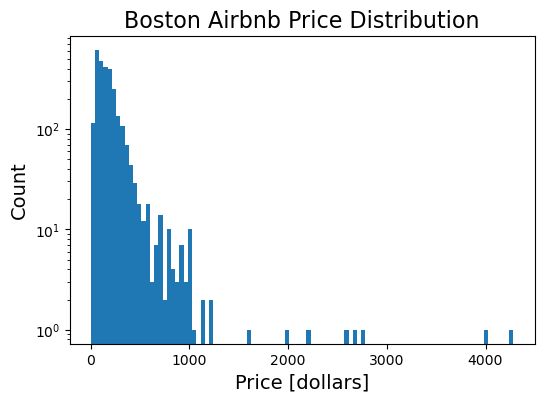

In [19]:
# Plot a histogram of price
hist_plotter(lstn.price, bins = 100, log = True)

plt.title('Boston Airbnb Price Distribution', size = 16)
plt.xlabel('Price [dollars]', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.savefig('../images/price_dist.png')
plt.show()

In [20]:
'''
To take the log of the price data, the $0 listings must first be
imputed with some value that can be log-transformed.

All $0 listings will be imputed with 1 as $1 is basically $0 in
terms of Air BnBs.
''';

# See how many listings are $0
print('Number of $0 listings: ', sum(lstn.price == 0))

# Impute 1 for 0 where price is 0 and take the log
#  Help with this code from:  https://www.geeksforgeeks.org/how-to-use-if-else-elif-in-python-lambda-functions/
log_price = np.log(lstn.price.apply(lambda x: 1 if x==0 else x))

Number of $0 listings:  1


In [21]:
# Check log_price
log_price

0       5.484797
1       5.669881
2       3.583519
3       4.290459
4       6.656727
          ...   
2776    5.932245
2777    5.214936
2778    4.948760
2779    4.127134
2780    3.784190
Name: price, Length: 2781, dtype: float64

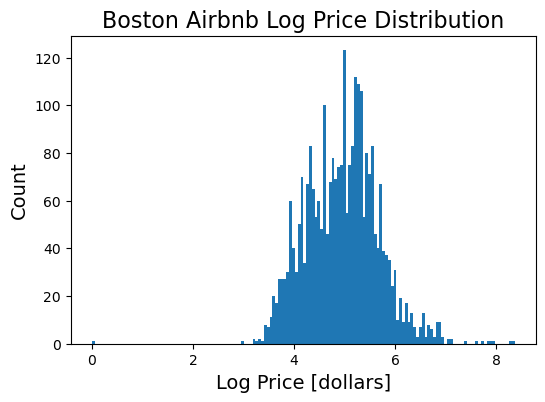

In [22]:
# Plot a histogram of the log price
hist_plotter(log_price, title = 'log price', bins = 150)

plt.title('Boston Airbnb Log Price Distribution', size = 16)
plt.xlabel('Log Price [dollars]', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.savefig('../images/log_price_dist.png')
plt.show()

#### OBSERVATIONS:
* Taking the logarithm of the price data helps to normalize its distribution which could be beneficial for modeling
* The price ditribution shows a vareity of outliers above $1000 per night. However, as they are so few in quantity, it's undetermined if they will have a big impact on the model

# 5 - Examine Possible Features

## 5.1 - Explore Numerical Features
Features which are already numerical datatypes will be examined in greater detail.  Other datatypes will be left for later processing in subsequent sections of this notebook.

In [23]:
# Create a list of numerical columns dropping the listing and host ids
num_cols = lstn.drop(columns = ['id', 'host_id'])._get_numeric_data().columns

In [24]:
# Source for this code: https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas
#  The host and listing ids need to be dropped to make this table more human readable (get rid of scientific notation)
lstn[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
host_listings_count,2781.0,469.027328,1336.724486,1.000000,2.00000,12.000000,84.00000,4807.000000
host_total_listings_count,2781.0,627.507371,1505.023931,1.000000,3.00000,16.000000,127.00000,5358.000000
latitude,2781.0,42.337007,0.027368,42.235300,42.32098,42.344480,42.35431,42.391317
longitude,2781.0,-71.082312,0.033053,-71.173486,-71.10036,-71.073072,-71.06081,-70.996000
accommodates,2781.0,3.167566,2.213750,1.000000,2.00000,2.000000,4.00000,16.000000
bedrooms,2438.0,1.754307,1.219764,1.000000,1.00000,1.000000,2.00000,13.000000
beds,2711.0,1.790483,1.440709,1.000000,1.00000,1.000000,2.00000,22.000000
price,2781.0,188.385832,208.367294,0.000000,83.00000,146.000000,225.00000,4283.000000
minimum_nights,2781.0,30.998921,39.439850,1.000000,2.00000,28.000000,32.00000,400.000000
maximum_nights,2781.0,671.235167,452.437459,2.000000,365.00000,368.000000,1125.00000,1125.000000


In [25]:
# Check out numerical columns for null values
lstn[num_cols].isnull().sum().sort_values(ascending=False)[listings.isnull().sum() >0]

review_scores_value            815
review_scores_location         815
review_scores_checkin          815
review_scores_accuracy         815
review_scores_communication    814
review_scores_cleanliness      814
reviews_per_month              809
review_scores_rating           809
bedrooms                       343
beds                            70
dtype: int64

In [26]:
'''
From the summary stats above, it seems odd that the median number of people accommodated by a listing
would be less than the number of beds if we assume that most people would want to sleep one person
per bed.  The shape of the code below will indicate how many listings exibit this behavior.
'''
lstn[lstn.beds < lstn.accommodates].shape

(2245, 53)

#### OBSERVATIONS:
* All of the reviews columns have a high number of missing values, nearly one-third of the data
    * It would be difficult to justifiably impute this data given how many values are missing
    * It is probably best to drop this data unless the correlation for the populated data against price proves to be substantial
* Bedrooms have over 10% of the data missing, but it can argued that this feature is important enough to impute
    * The median value of 1 should be imputed where there are missing values
* The same is true of beds which will also be imputed with the median value of 1
* In the case of reviews per month, it needs to be determined if this is due to the fact that there are no reviews for these posts.  In which case, it would make sense to impute missing values with a 0

In [27]:
# Impute median values in beds and bedroom
lstn.bedrooms.fillna(lstn.bedrooms.median(), inplace=True)
lstn.beds.fillna(lstn.beds.median(), inplace=True)

In [28]:
# See how many toal reivews there are where reviews per month is null
lstn[lstn.reviews_per_month.isnull() == True]['number_of_reviews'].value_counts()

0    809
Name: number_of_reviews, dtype: int64

#### OBSERVATIONS:
In all instnaces where the number of reviews per month is null, there are 0 total reviews for the listing.

From this, 0 will be imputed into reviews per month.

In [29]:
# Impute 0 for reviews per month
lstn.reviews_per_month.fillna(0, inplace = True)

C:\Users\Dan\AppData\Local\Temp\ipykernel_17612\2697494567.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = size)


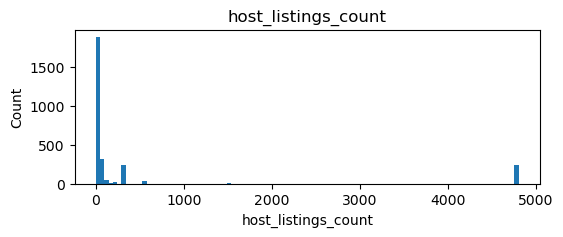

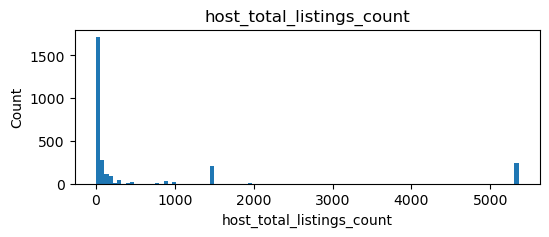

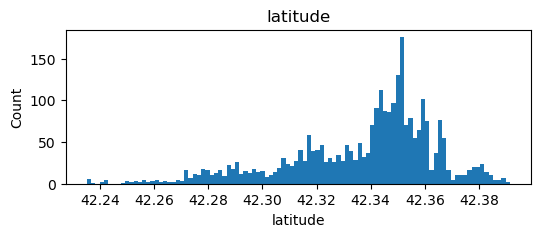

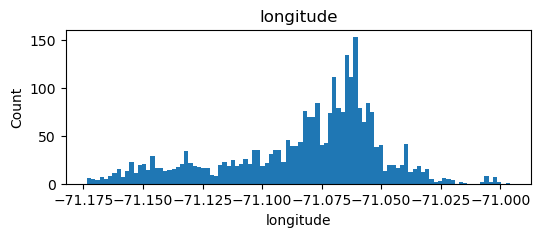

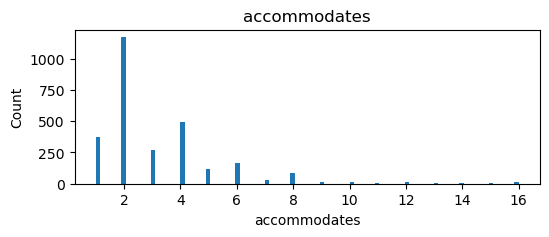

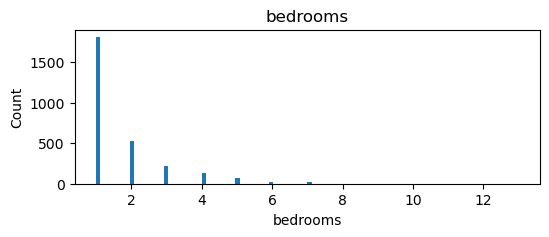

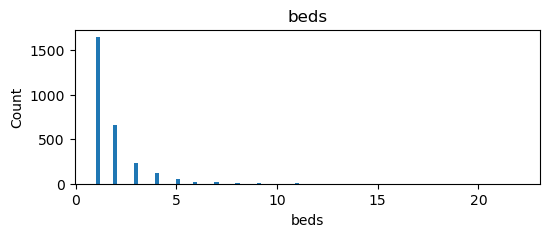

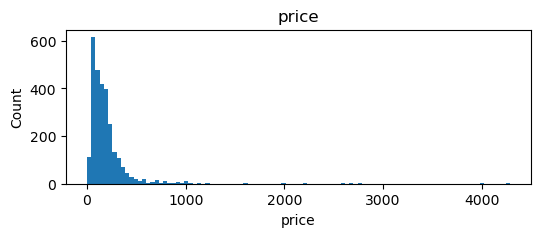

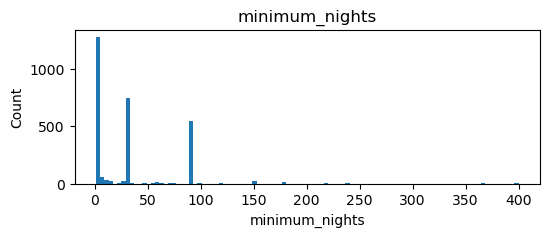

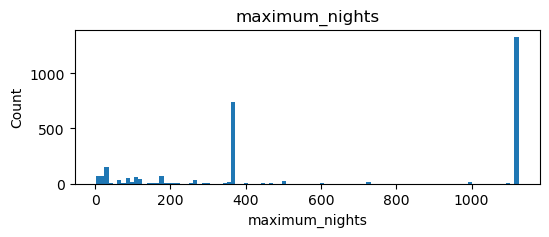

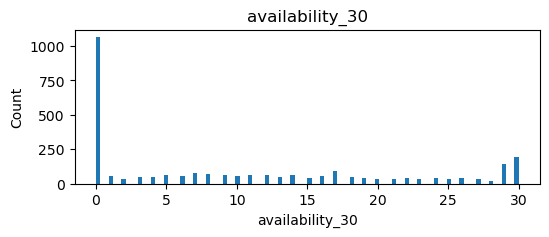

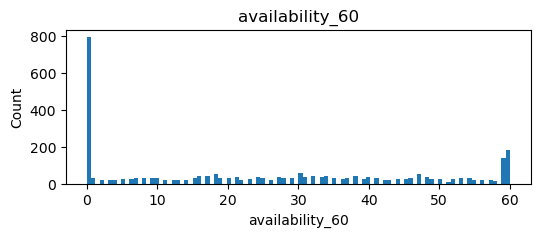

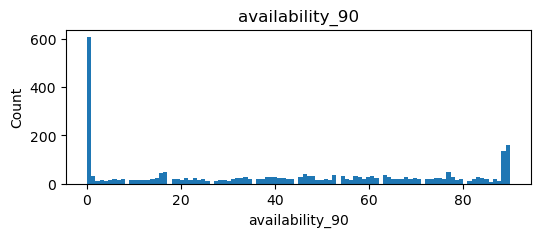

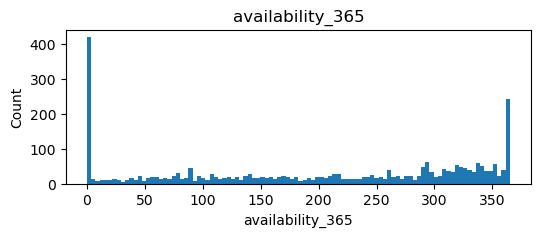

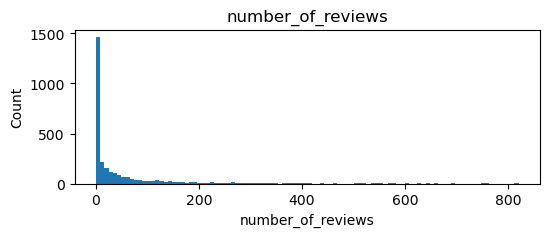

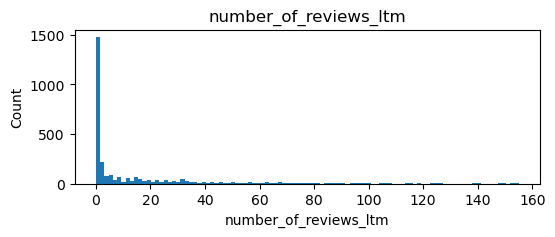

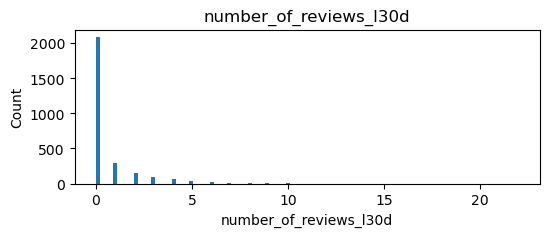

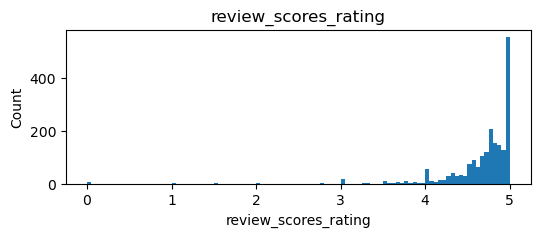

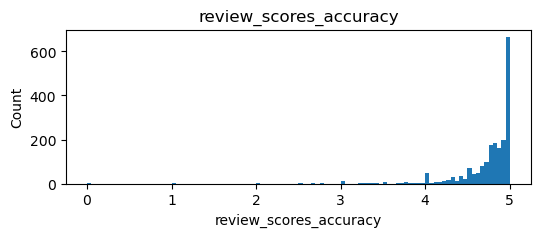

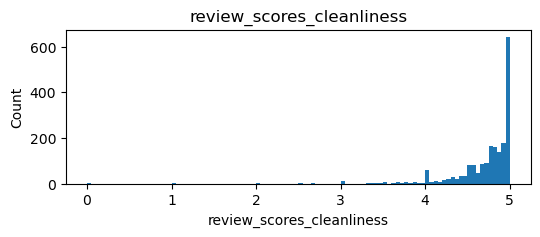

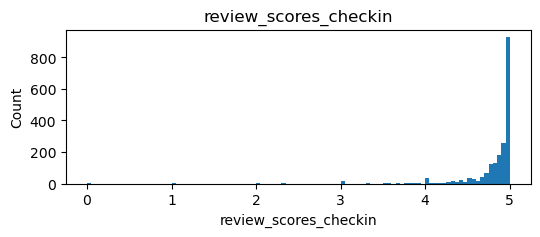

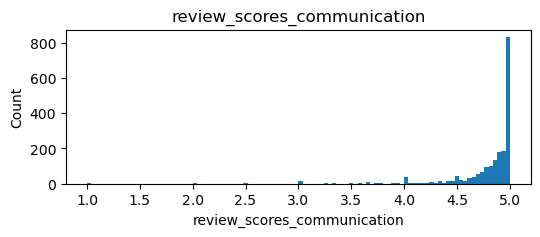

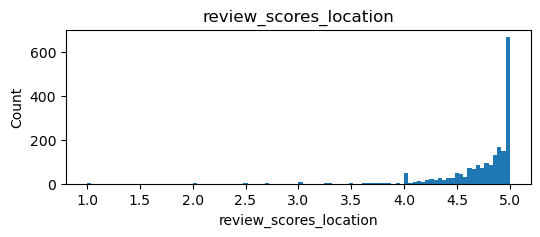

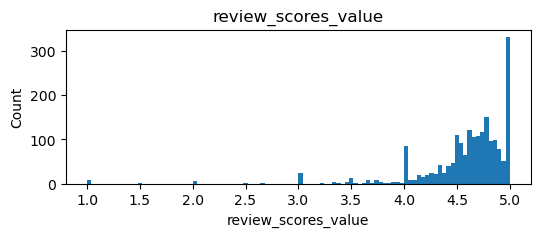

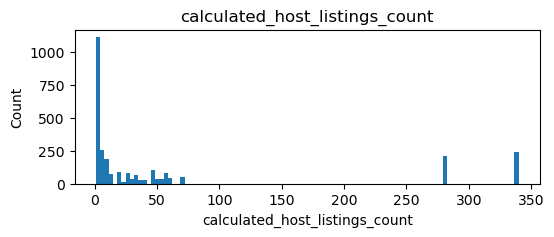

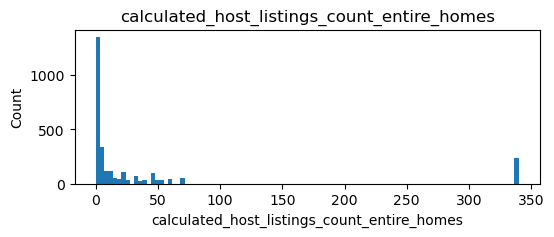

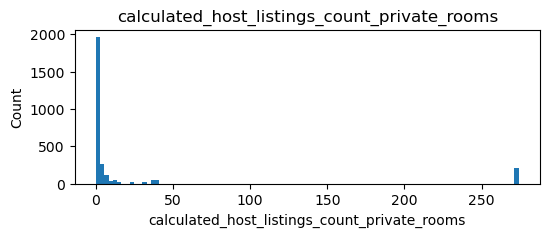

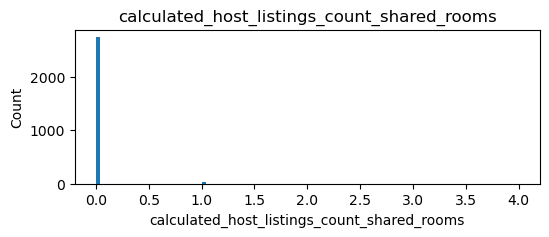

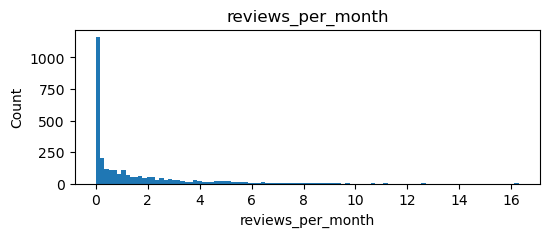

In [30]:
# Loop through the columns and create histogram plots
for i in num_cols:
    hist_plotter(lstn[i], size = (6,2), bins = 100)

#### OBSERVATIONS:
Not all numerical columns will be commented on.  Some intersting insights are as follows:
* Odd numbers for the 'accomodates' feature appear to be more frequent.  Probably due to home design and people traveling in couples
    * It might be good to one hot encode this variable
* The minimum available nights appear to be relatively low, but peak around 0 (or probably 1) days, 30days, and 90 days
    * This may also be a good feature to one hot encode or bin
* Reviews in-general tend to be very high, many of them being over 4.5
    * It may be good to bucketize these ratings by quantiles in order to understand what's going on
    * This may be especailly usefult for the 'value' reviews
* The count of host listings may also indicate why type of host is posting a particular listing
    * The type of host may then have something to do with the price
    * For this it would also be useful to calcualte percentages of each type of listing as this may also indicate the type of host

C:\Users\Dan\AppData\Local\Temp\ipykernel_17612\2718215604.py:86: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')
C:\Users\Dan\AppData\Local\Temp\ipykernel_17612\2718215604.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = size)


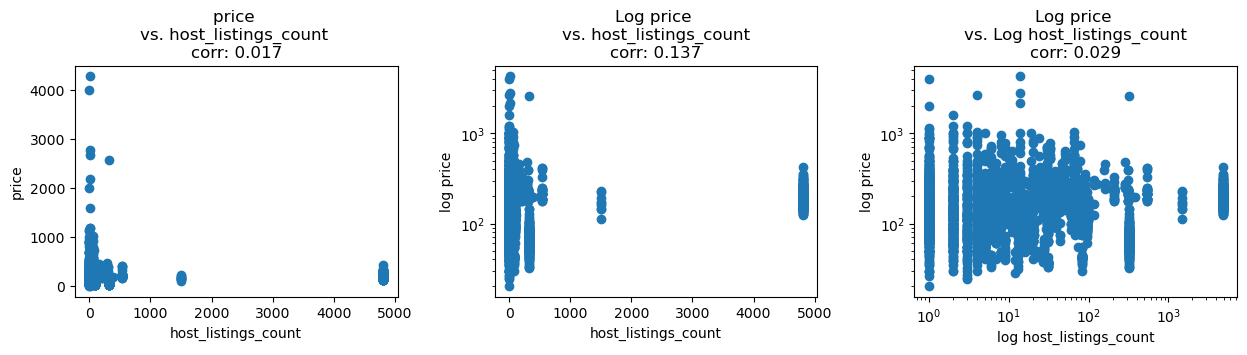

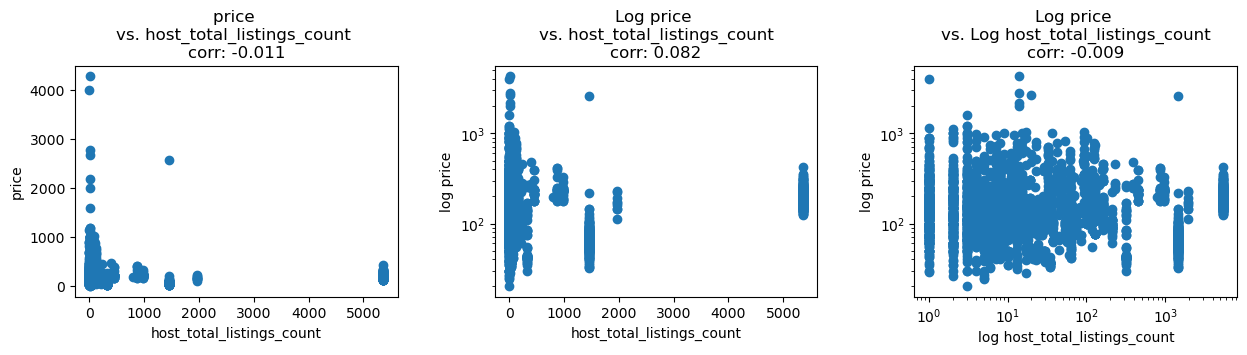

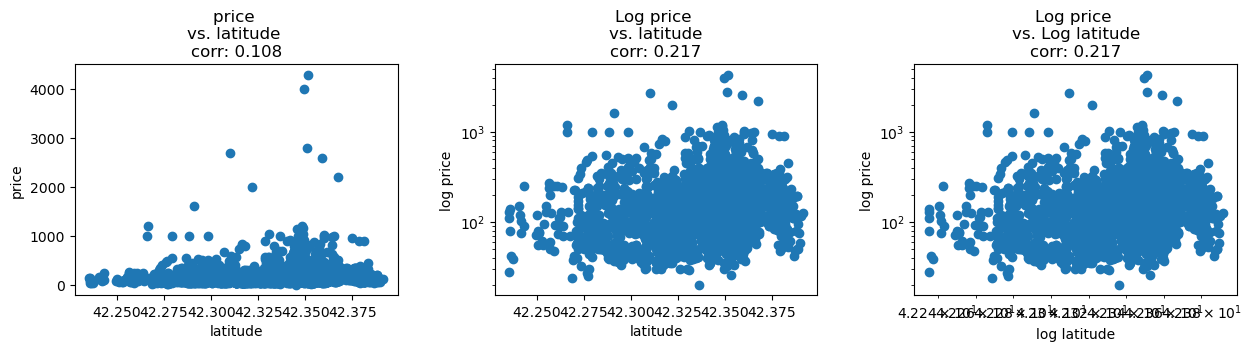

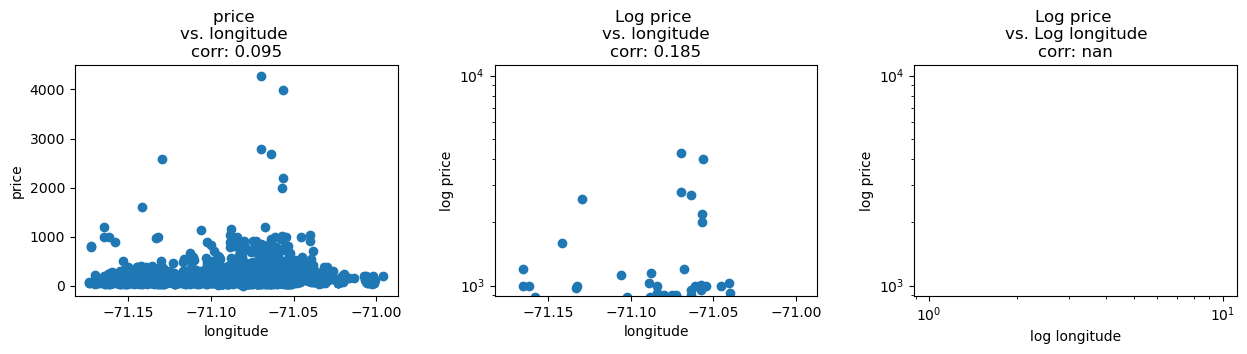

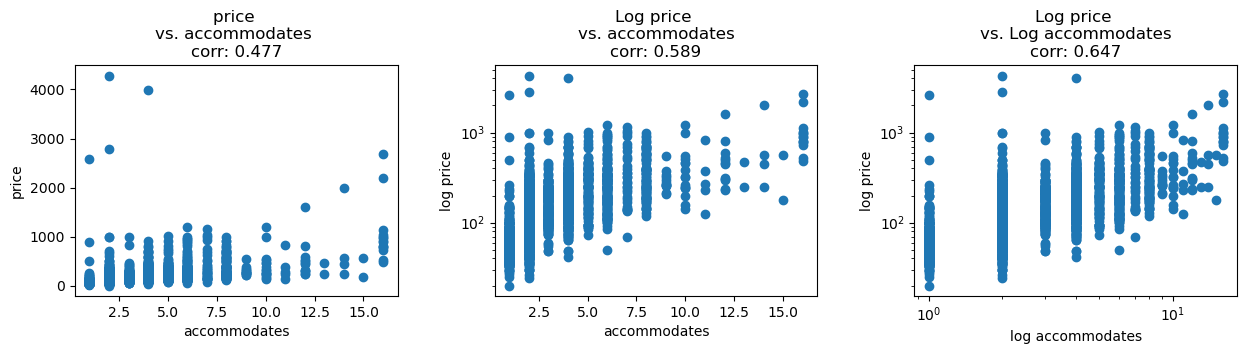

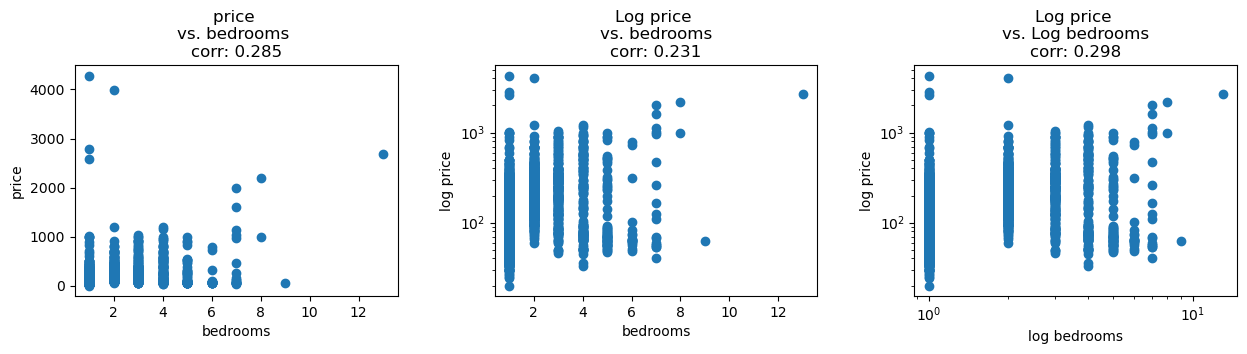

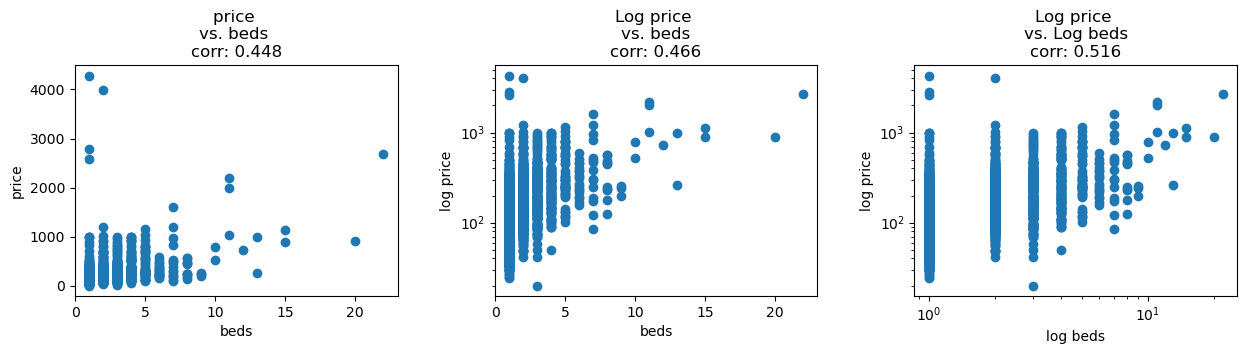

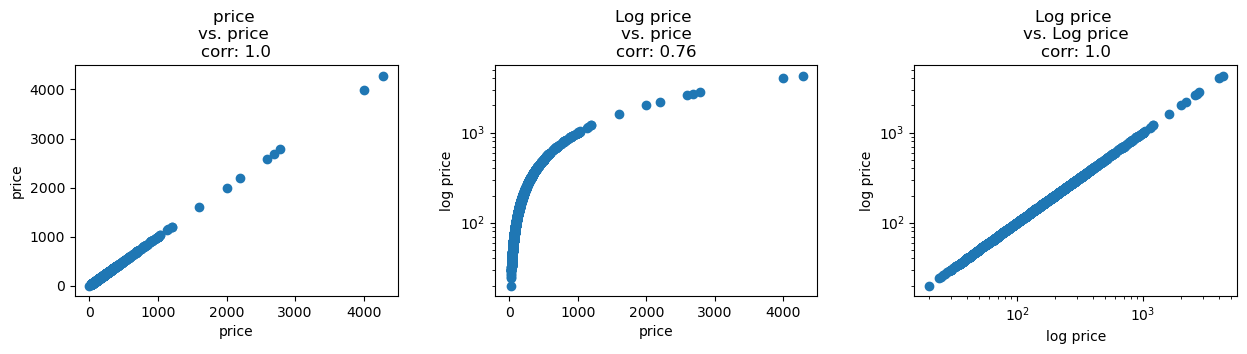

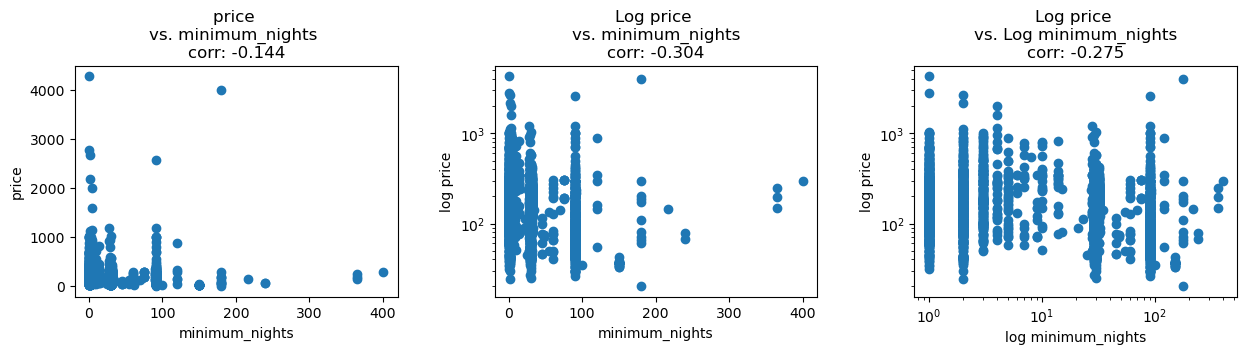

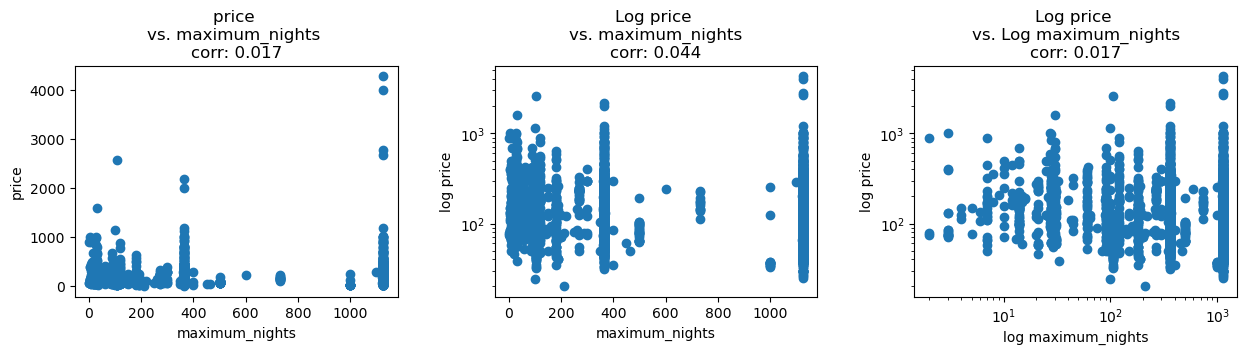

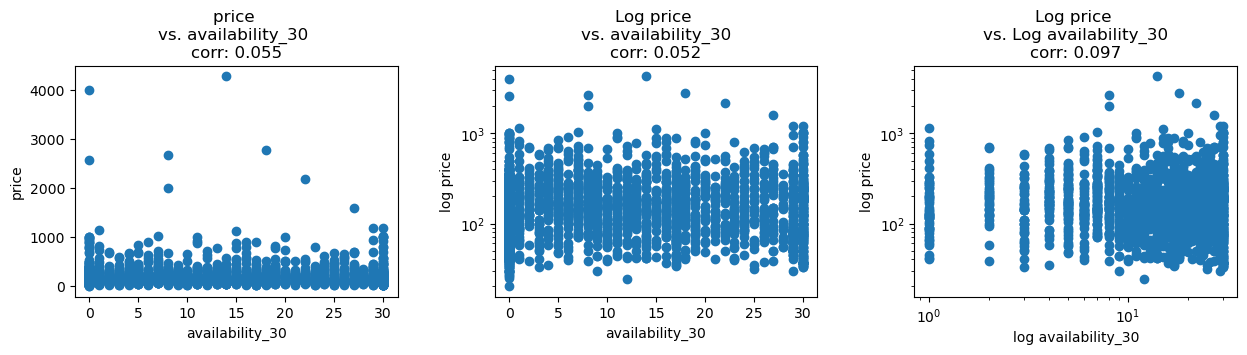

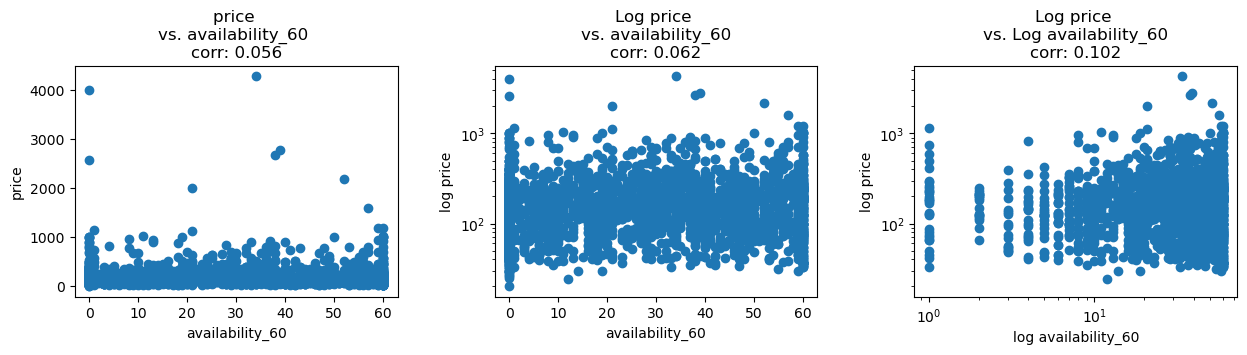

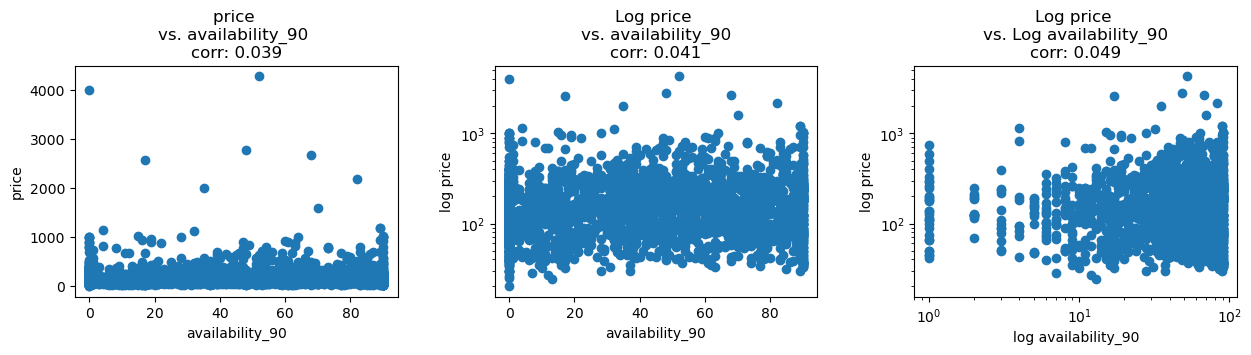

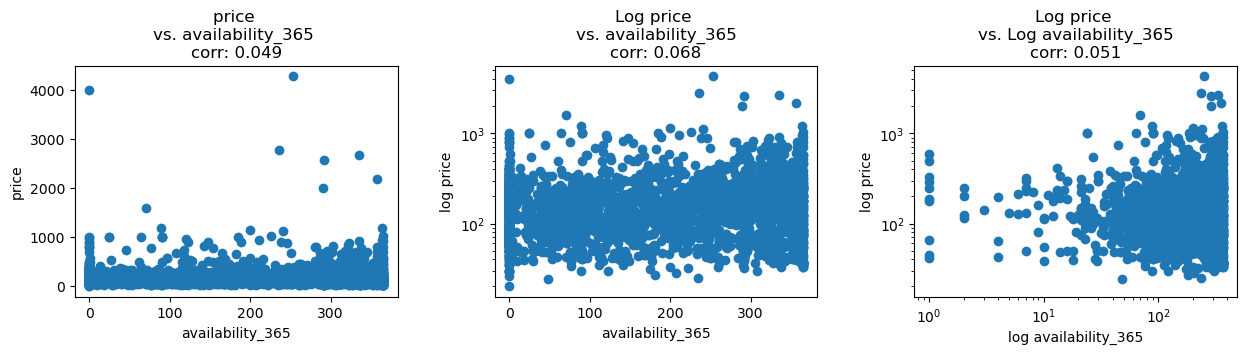

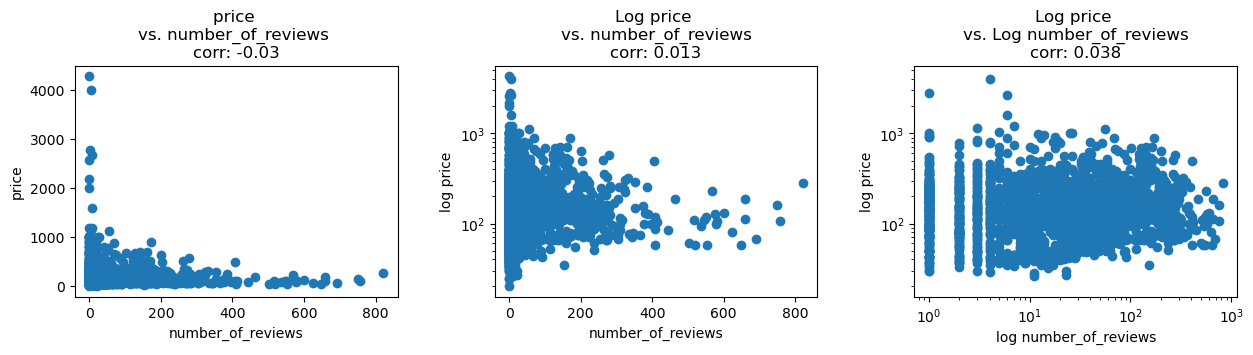

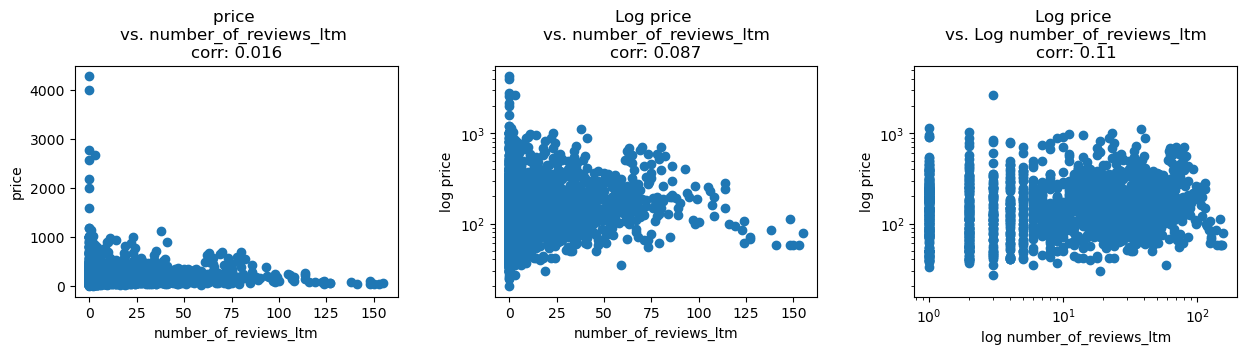

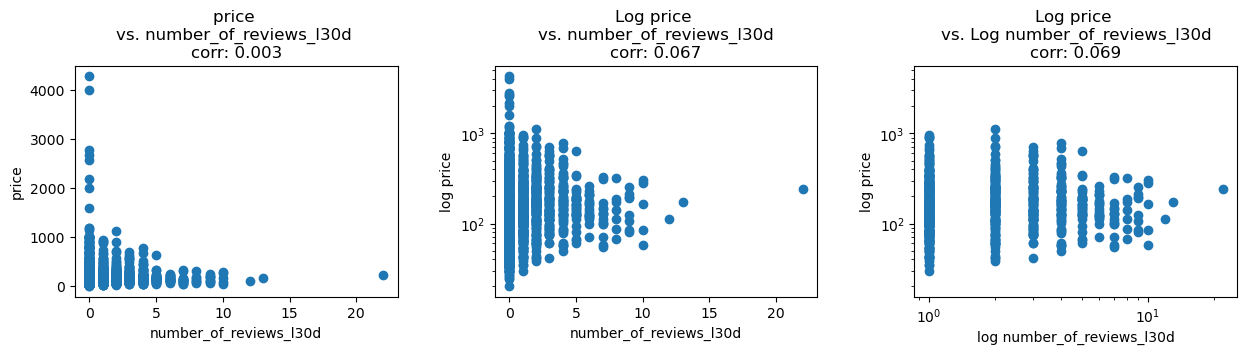

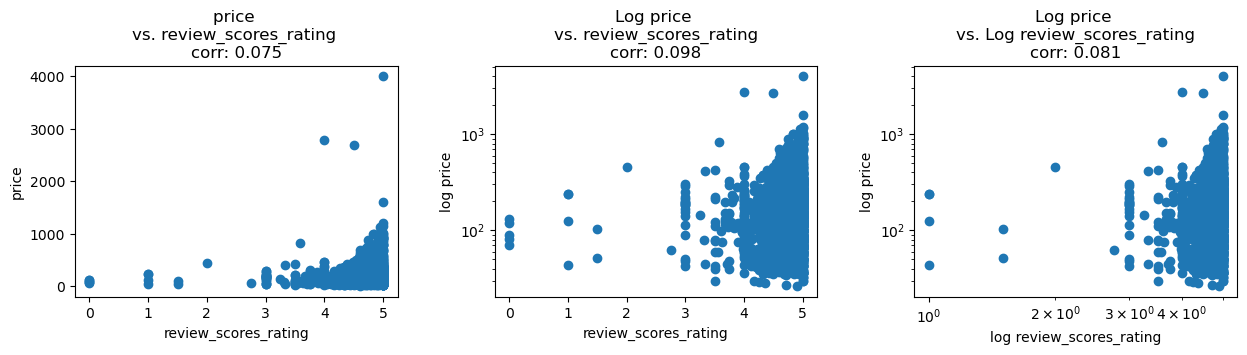

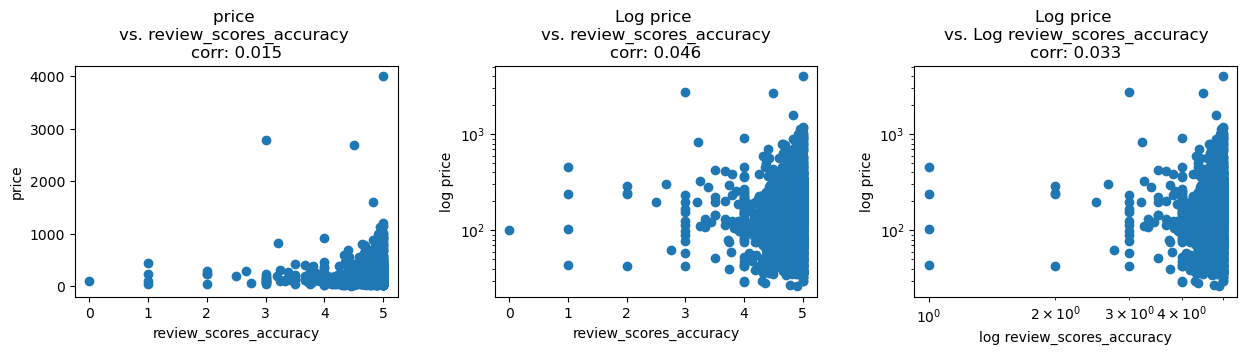

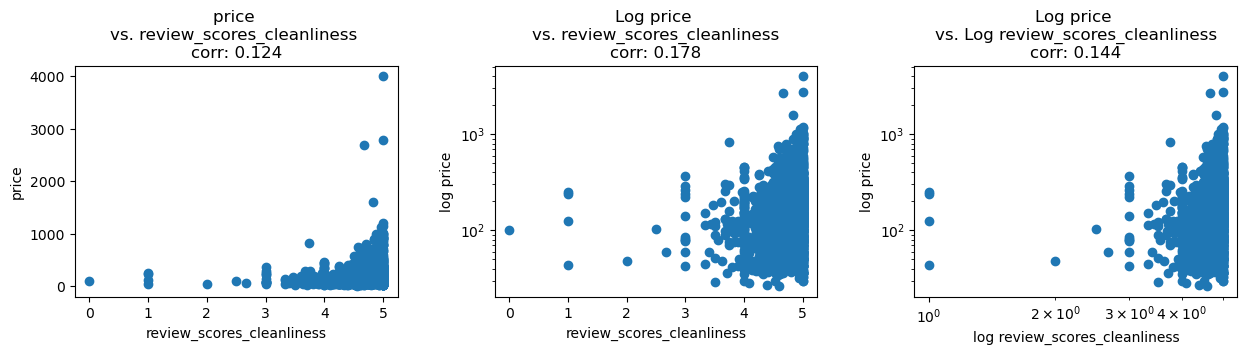

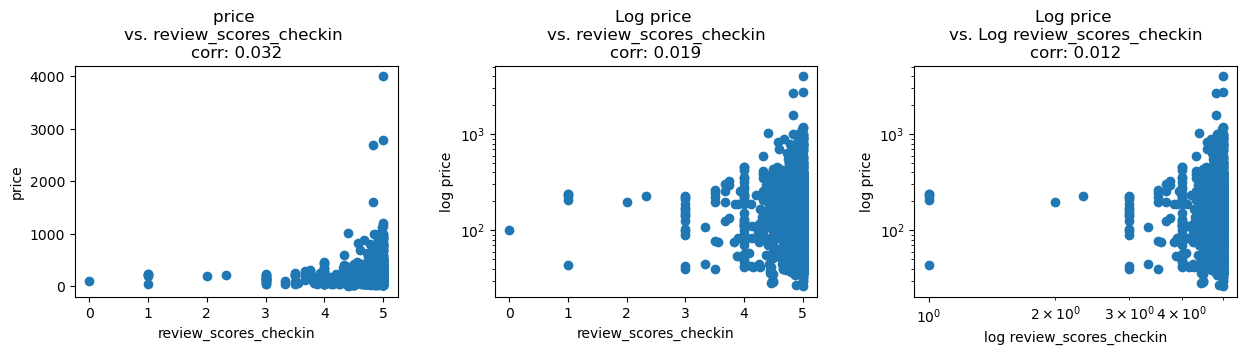

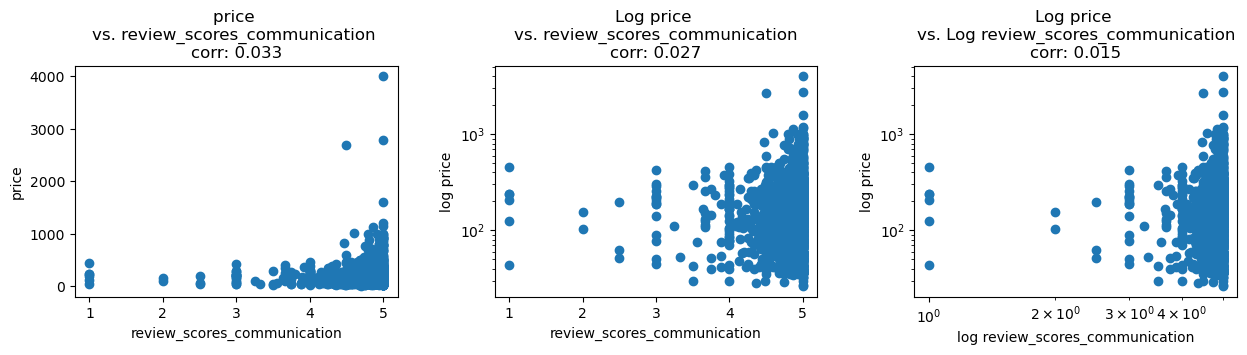

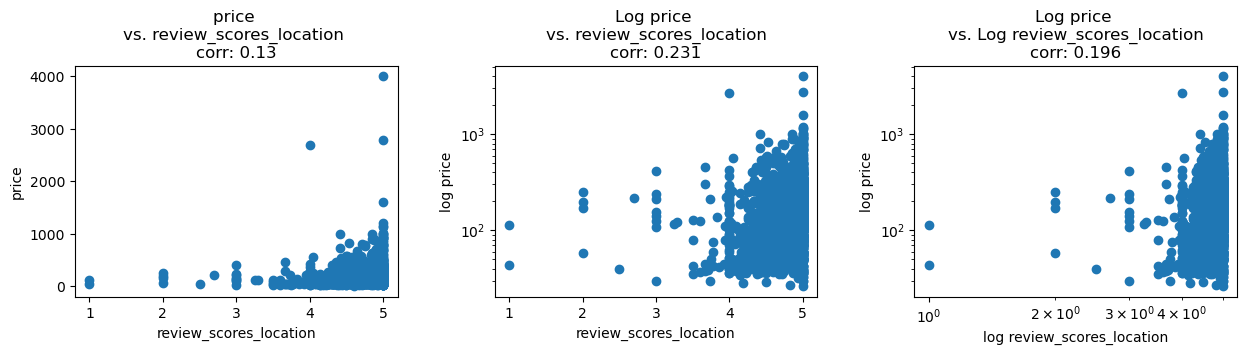

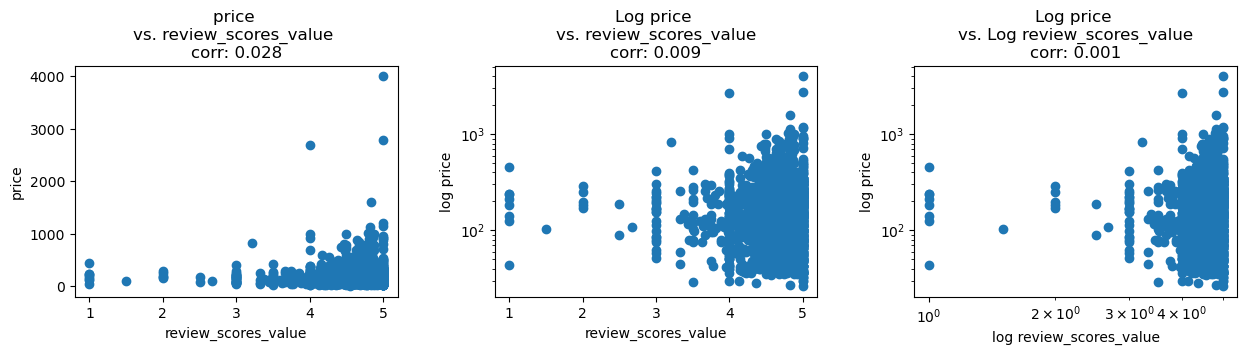

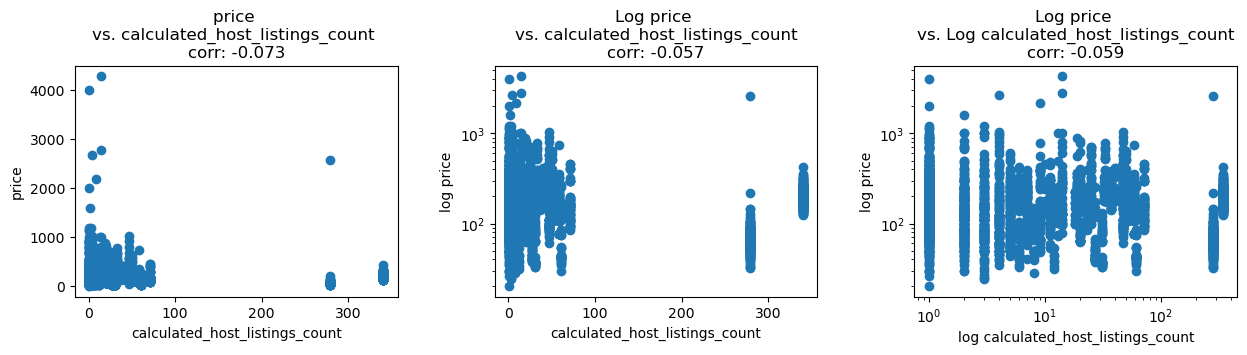

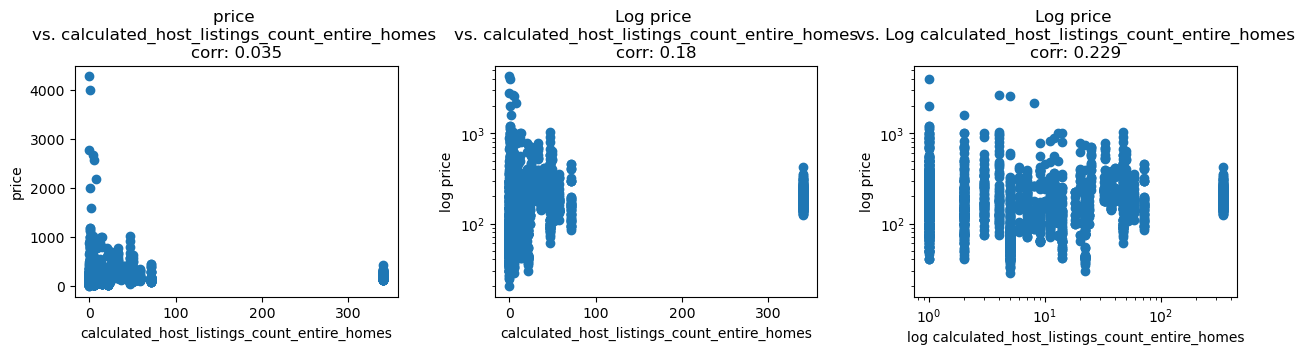

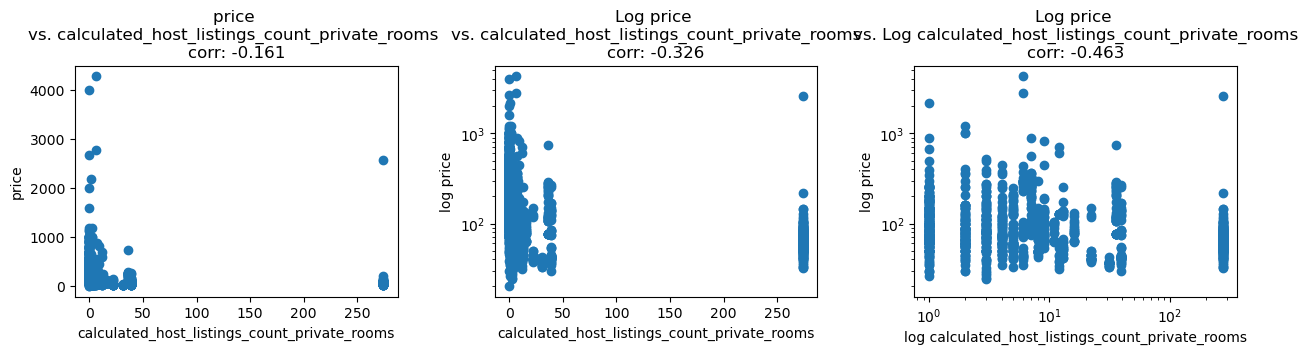

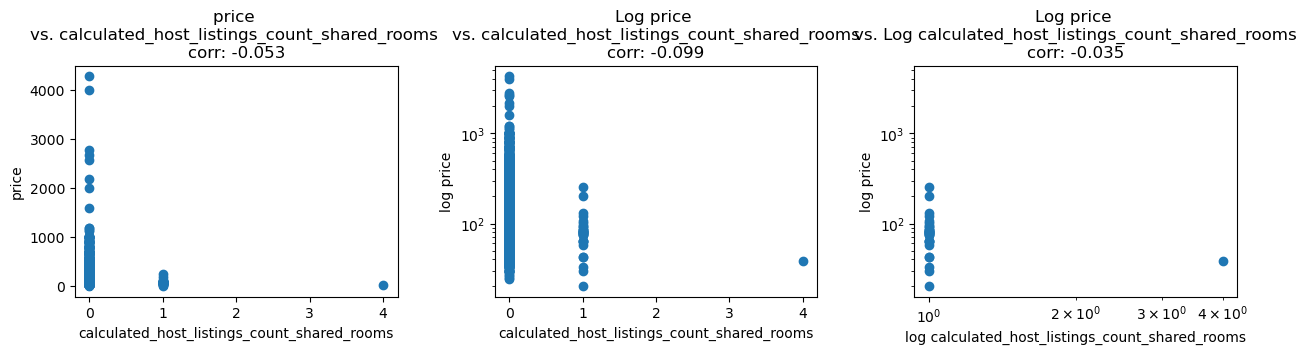

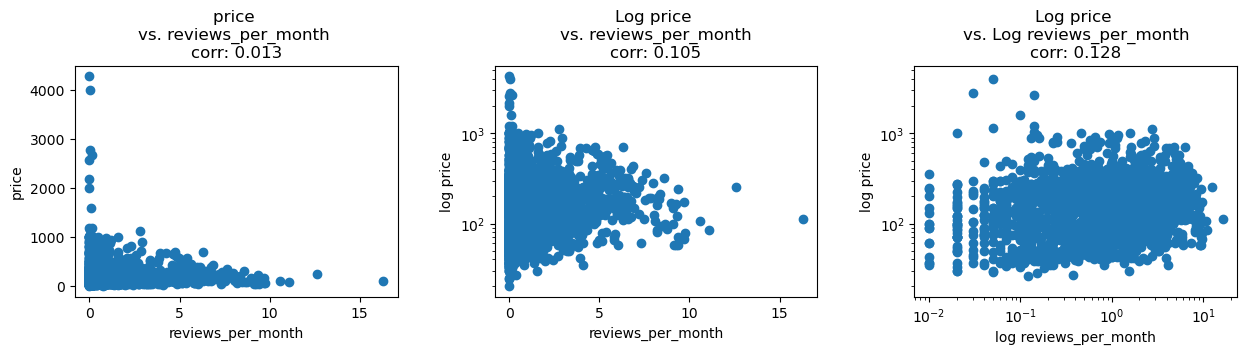

In [31]:
# Loop through and create plots to view correlations between numerical features and price
for i in num_cols:
    plot_vs_log(lstn[i], lstn.price, size = (15, 3))

#### OBSERVATIONS:
* The price appears to correlate most strongly with how many people the listing accommodates
* The next most highly-correlated features to price are the number of beds followed by the number of bedrooms
* The next two most correlated features with correlation coefficients of approximately 0.13 are the minimum nights and the calcualted number of listings of private rooms that the host has
    * Both of these are negative correlations
    * Both also point to economies of scale, meaning that things get cheaper as:
        * The minimum number of nights increases
        * The host handles more properties
* The log plots are sometimes useful in seeing relationships that may otherwise not be apparent

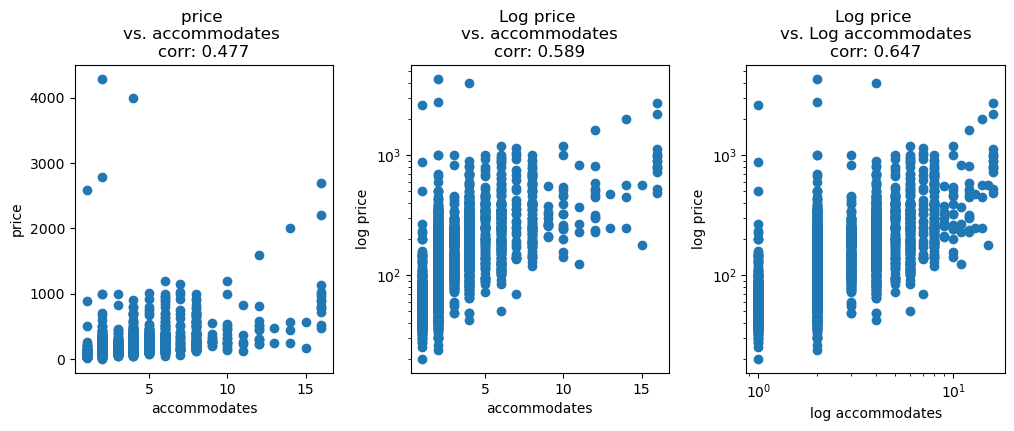

In [32]:
# Create a plot for the presentation
plot_vs_log(lstn['accommodates'], lstn.price, size = (12, 4))
plt.savefig('../images/price_v_accom.png')

## 5.2 - Examine Other Numerical Features
These features require some additional preparation.  Most of these features are date features which are currently object data types.  They will be converted to datetime, then to epoch time, and then to an integer to allow for a correlation to be calculated and to be used in models.  The epoch time is useful since it removes the months, days, and years, and is a great way to represent how recent a particular date is.
* NOTE:  After some analysis, the high number of NaN values in the first and last review columns would require more time-consuming imputation methods prior to converting to datetime and ultimately epoch time.  Thus, these columns will not be included further. **The dropped columns list used to create the 'lstn' dataframe will be (has been) updated to also remove these columns**

Other features are percentages and need to be converted to float values.

Additionally, this is a good place to add in the percentages of each type of listing that makes up each host's listing portfolio.

### 5.2.1 - Host Since Column

In [33]:
'''
The method used below to convert to epoch time was discovered with the help of ChatGPT.
Per the lead instructor, it is ok to use ChatGPT is a search tool provided that we provide the
question that was asked:

Question:  'in python, I want to convert a pandas datetime object to epoch time'

Additional help from:  https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
'''

# The strings are converted to date time, then to epoch time with '.timestamp()'
# The epoch time is then divided by the product the number of hours and seconds per day
#   to get the number of days since the epoch time origin 
lstn['host_since'] = pd.to_datetime(lstn['host_since']).apply(lambda x: x.timestamp()/(3600*24))

In [34]:
lstn['host_since'].head()

0    17162.0
1    19213.0
2    16272.0
3    18164.0
4    17140.0
Name: host_since, dtype: float64

#### Host Acceptance and Reposnse Rates

In [35]:
# Find the number of null values for each column
lstn.host_acceptance_rate.isnull().sum(), lstn.host_response_rate.isnull().sum()

(329, 377)

In [36]:
'''
Since the null values are not a very big percentage of the total data (though not a small percentage either),
the data will be imputed with the median value
'''
# Convert percentages where they can be converted
lstn.host_acceptance_rate = lstn.host_acceptance_rate.apply(lambda x: pcnt_floater(x))
lstn.host_response_rate = lstn.host_response_rate.apply(lambda x: pcnt_floater(x))

In [37]:
# Use fillna to impute the median value
lstn.host_acceptance_rate = lstn.host_acceptance_rate.fillna(lstn.host_acceptance_rate.median())
lstn.host_response_rate = lstn.host_response_rate.fillna(lstn.host_response_rate.median())

### 5.2.2 - Host Listing Percentages

In [38]:
# Chcek for nulls
for col in ['calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', ]:
    print(lstn[col].isnull().sum())

0
0
0
0


In [39]:
# Make new columsn that represent the percentages of each type for eeach listing/host
lstn['pcnt_ent_homes'] = round(lstn['calculated_host_listings_count_entire_homes'] / lstn['calculated_host_listings_count'], 3)
lstn['pcnt_private'] = round(lstn['calculated_host_listings_count_private_rooms'] / lstn['calculated_host_listings_count'], 3)
lstn['pcnt_shared'] = round(lstn['calculated_host_listings_count_shared_rooms'] / lstn['calculated_host_listings_count'], 3)

### 5.2.3 - Run Plots on Modified/New Numerical Columns

In [40]:
# Make a list of columns to iterate over:
new_num_cols = ['host_since', 'host_acceptance_rate', 'host_response_rate', 'pcnt_ent_homes', 'pcnt_private', 'pcnt_shared']

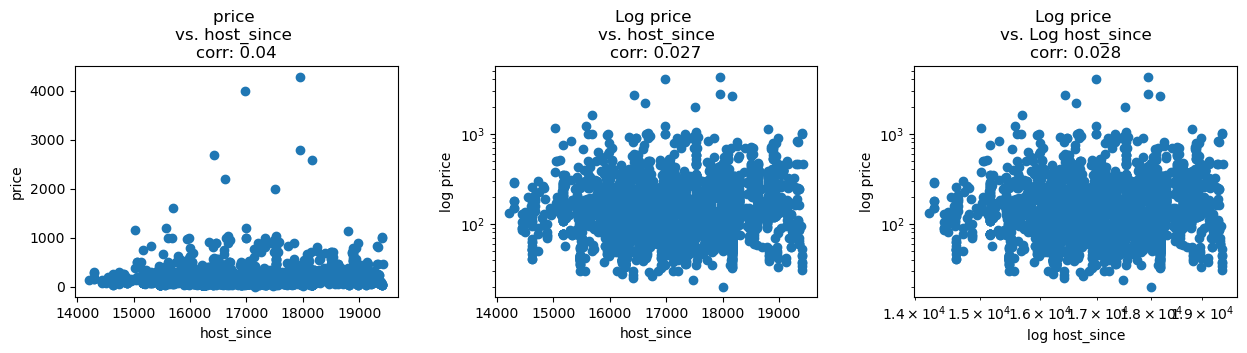

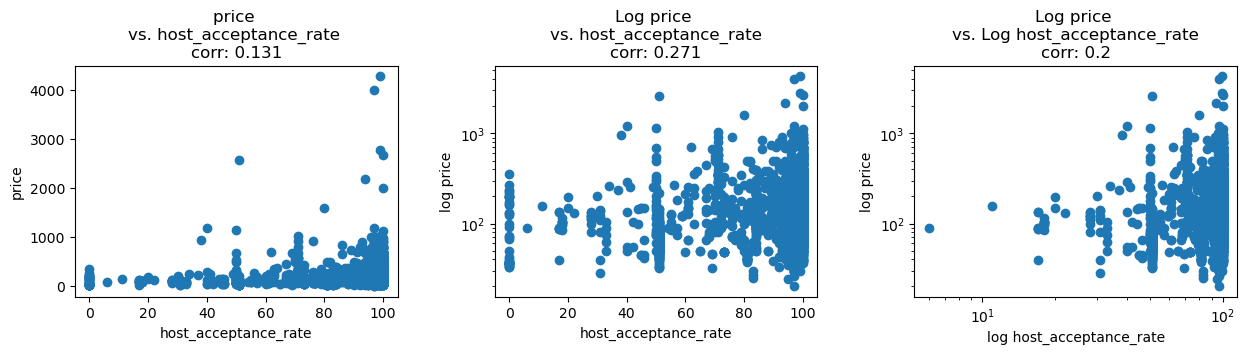

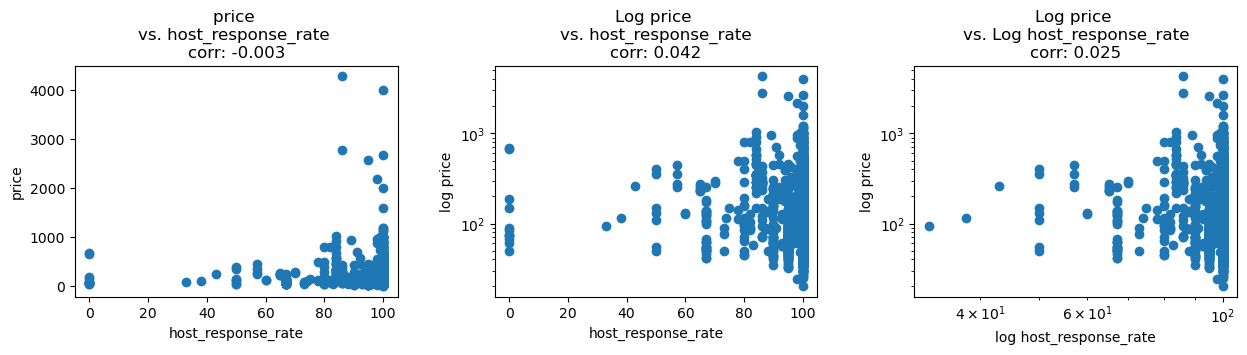

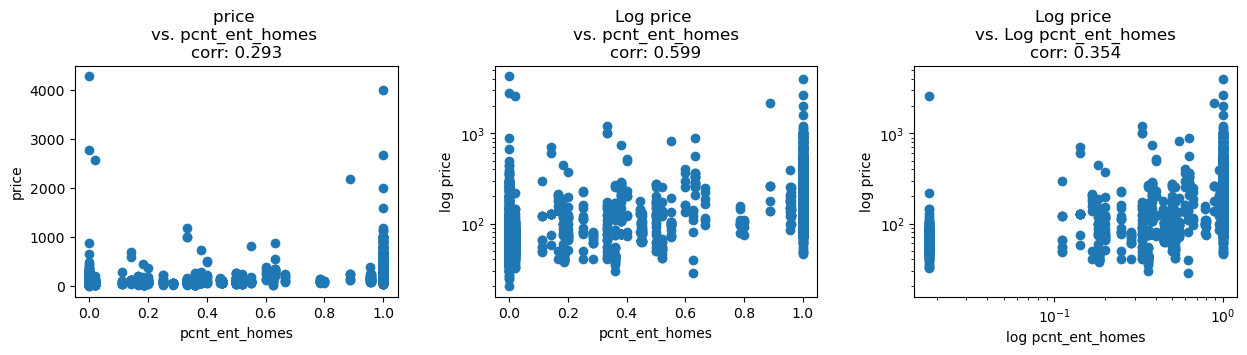

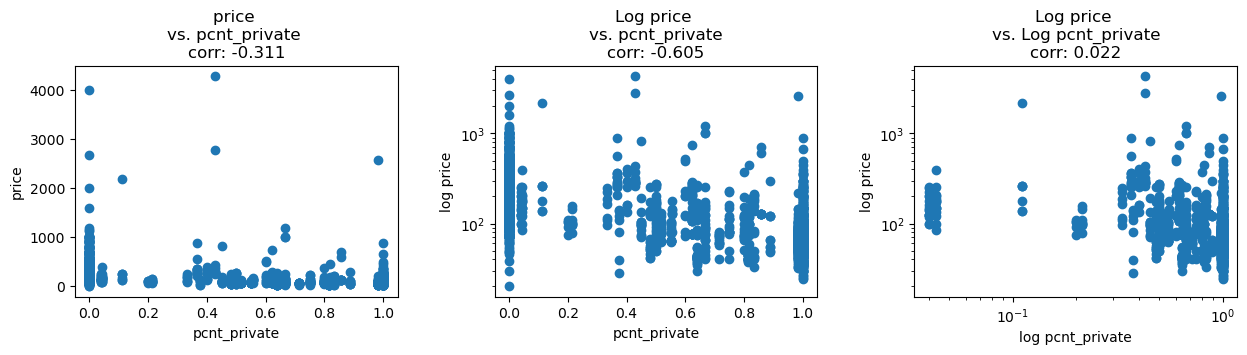

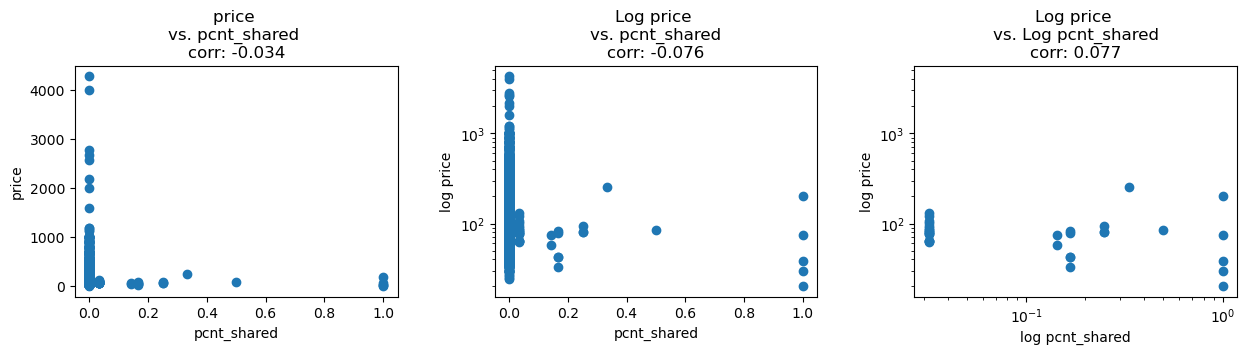

In [41]:
# Running ploting function through loop
for i in new_num_cols:
    plot_vs_log(lstn[i], lstn.price, size = (15, 3))

#### OBSERVATIONS:
* The host's percatages of entire home listings and private room listings seem to correlate comparatively well to the listing price
* The host acceptance rate has a relatively high correlation (relatively at 0.21) to price.  Other columns are not correlated

## 5.3 - Explore Categorical Features

In [42]:
# Create a a list of catgorical features
set(lstn.columns) - set(num_cols)

{'amenities',
 'bathrooms_text',
 'description',
 'has_availability',
 'host_about',
 'host_acceptance_rate',
 'host_has_profile_pic',
 'host_id',
 'host_identity_verified',
 'host_is_superhost',
 'host_location',
 'host_neighbourhood',
 'host_response_rate',
 'host_response_time',
 'host_since',
 'host_verifications',
 'id',
 'instant_bookable',
 'license',
 'name',
 'neighborhood_overview',
 'neighbourhood_cleansed',
 'pcnt_ent_homes',
 'pcnt_private',
 'pcnt_shared',
 'property_type',
 'room_type'}

In [43]:
'''
The following features from the above avhe been investigated previously with 
the help of the data dictionary list will be explored later in greater detail:
* amenities              - complex text data, requires special handling
* description            - complex text data, requires special handling
* host_about             - complex text data, requires special handling
* name                   - complex text data, requires special handling
* neighborhood_overview  - complex text data, requires special handling
* host_location          - values require special encoding
* host_neighbourhood     - values require special encoding 

These will be ignored as they were already processed or are not needed:
* host_acceptance_rate
* host_id
* host_response_rate
* host_since
* id
* pcnt_ent_homes
* pcnt_private
* pcnt_shared
'''

# Create a list of categorical columns to be processed
cat_cols = [
 'bathrooms_text',
 'has_availability',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_is_superhost',
 'host_response_time',
 'host_verifications',
 'instant_bookable',
 'license',
 'neighbourhood_cleansed',
 'property_type',
 'room_type'
]

In [44]:
# See how many of each feature there are:
for col in cat_cols:
    print(f'{col}: {lstn[col].nunique()}')

bathrooms_text: 21
has_availability: 2
host_has_profile_pic: 2
host_identity_verified: 2
host_is_superhost: 2
host_response_time: 4
host_verifications: 5
instant_bookable: 2
license: 862
neighbourhood_cleansed: 25
property_type: 36
room_type: 4


In [45]:
# Explore 'license' because there are so many unique values:
lstn.license

0                                              STR-521858
1                                              STR-485772
2                                                     NaN
3                                                     NaN
4       Exempt: This listing is a unit that has contra...
                              ...                        
2776                                           STR-393234
2777                                           STR-461740
2778                                                  NaN
2779                                                  NaN
2780                                           STR-522656
Name: license, Length: 2781, dtype: object

In [46]:
# View the top 50 unique licence values
lstn.license.value_counts()[0:50]

Exempt: This listing is a unit used for furnished institutional or business stays    147
Exempt: This listing is a hotel or motel                                             145
Exempt: This listing is a unit that has contracts with hospitals                     134
Approved by government                                                                30
STR-439290                                                                            18
STR-460218                                                                            15
STR-423861                                                                            10
STR-488469                                                                             8
STR-413441                                                                             7
LB-101745                                                                              7
STR439290                                                                              7
STR-446888           

#### NOTE:  License was not able to be evaluated in this phase of the project.  However, it will be examined at a later date.

#### OBSERVATIONS:

'License' needs to be evaluated separately from the other features.

The following sources provide additional information regarding the STR values above:
* https://www.boston.gov/departments/inspectional-services/short-term-rentals
* https://www.airbnb.com/help/article/859

In [47]:
# Remove license from the list
#  Source for help:  https://www.programiz.com/python-programming/methods/list/remove
cat_cols.remove('license')

In [48]:
# Count null values for each column:
for col in cat_cols:
    print(f'{col}: {lstn[col].isnull().sum()}')

bathrooms_text: 1
has_availability: 0
host_has_profile_pic: 0
host_identity_verified: 0
host_is_superhost: 1
host_response_time: 377
host_verifications: 0
instant_bookable: 0
neighbourhood_cleansed: 0
property_type: 0
room_type: 0


In [49]:
# Impute values for bathromms_text
lstn.bathrooms_text.fillna(lstn.bathrooms_text.mode()[0], inplace = True)

In [50]:
# check out values for host_is_superhost
lstn.host_is_superhost.value_counts()

f    2088
t     692
Name: host_is_superhost, dtype: int64

In [51]:
#Impute false (f) for host is superhost
lstn.host_is_superhost.fillna('f', inplace = True)

In [52]:
# Checl out host response time
lstn.host_response_time.value_counts()

within an hour        1858
within a few hours     398
within a day           133
a few days or more      15
Name: host_response_time, dtype: int64

In [53]:
# Fill NaN values with '0 - not listed'
#  The '0' is included to make this variable the first variable alphabetically
#   and thus the one that would be dropped after one hot encoding
lstn.host_response_time.fillna('0 - not listed', inplace = True)

In [54]:
# Count null values for each column:
for col in cat_cols:
    print(f'{col}: {lstn[col].isnull().sum()}')

bathrooms_text: 0
has_availability: 0
host_has_profile_pic: 0
host_identity_verified: 0
host_is_superhost: 0
host_response_time: 0
host_verifications: 0
instant_bookable: 0
neighbourhood_cleansed: 0
property_type: 0
room_type: 0


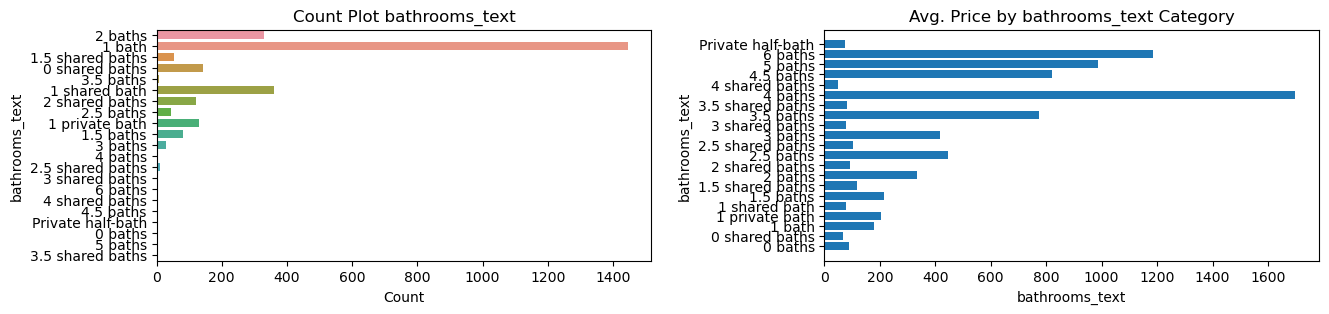

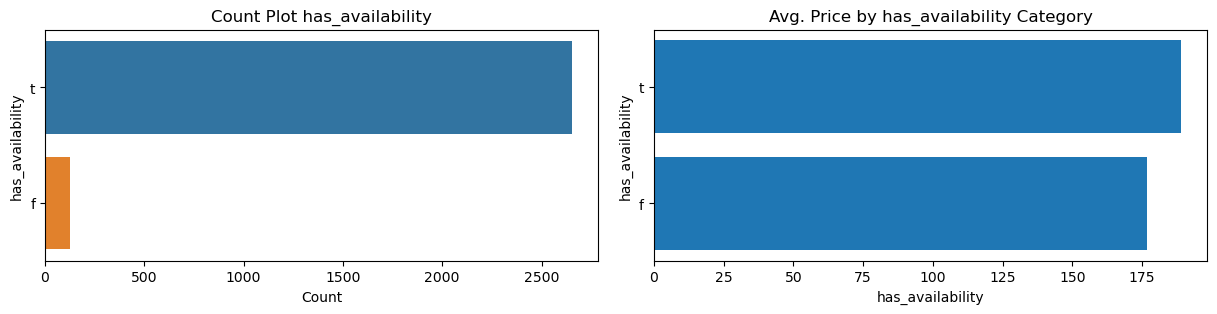

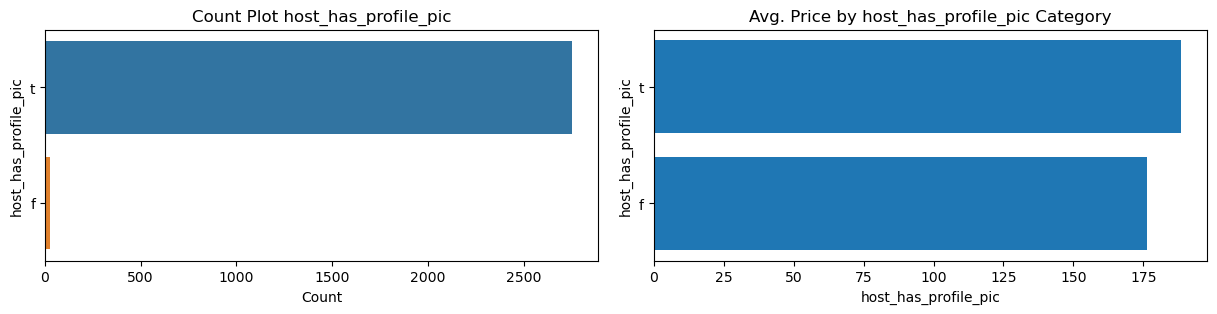

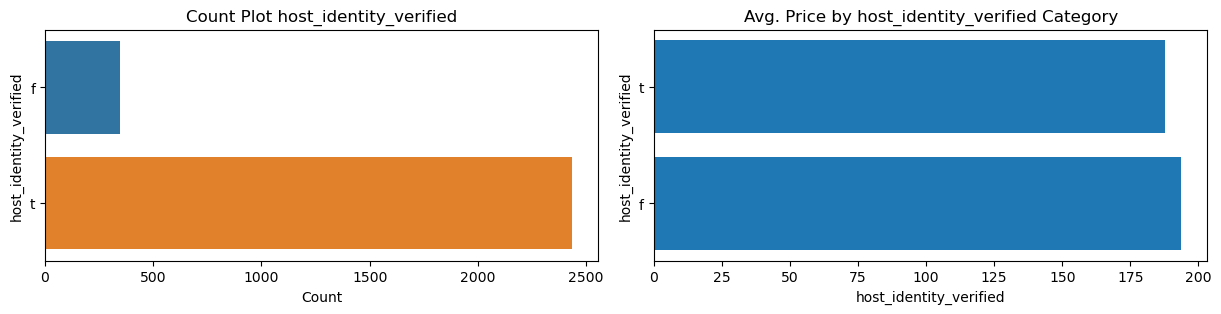

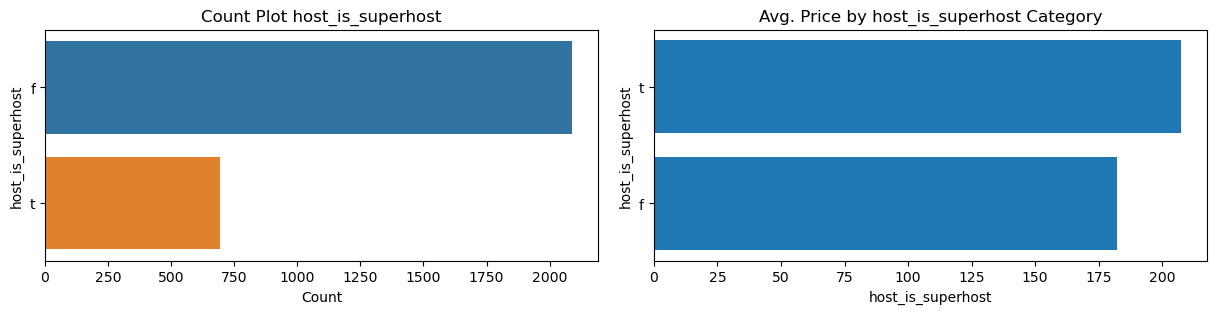

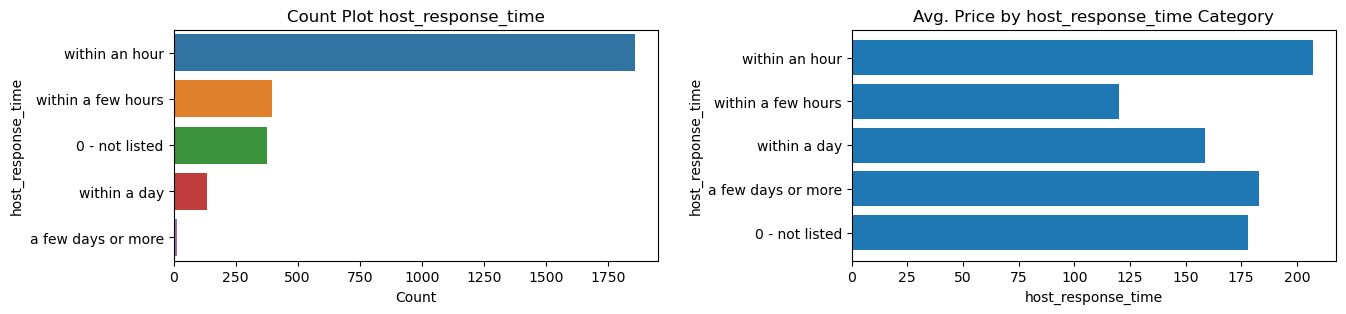

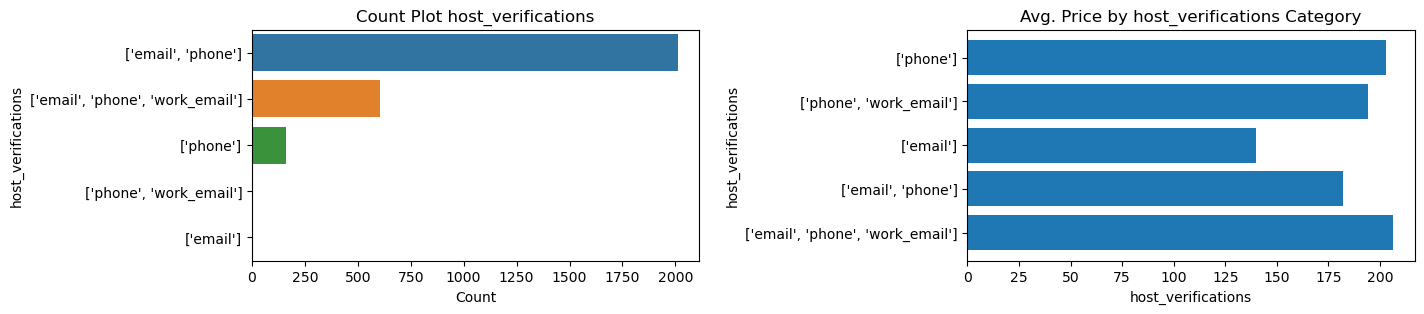

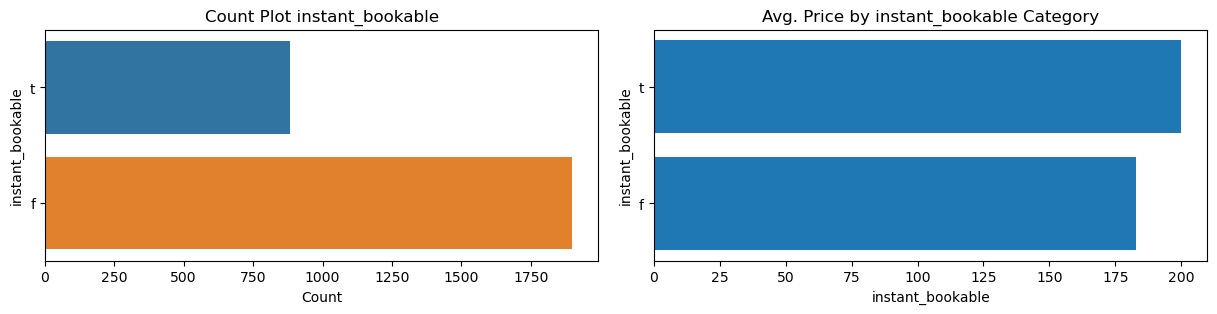

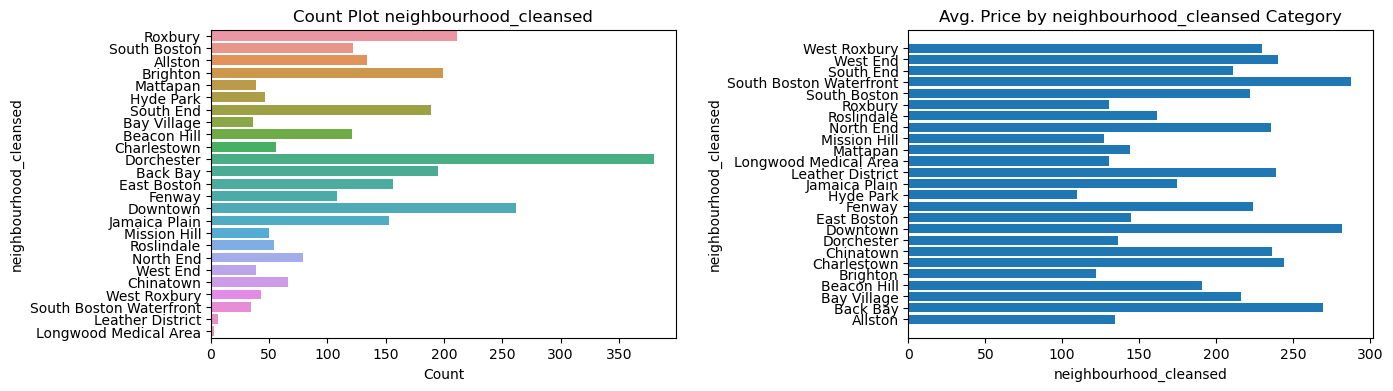

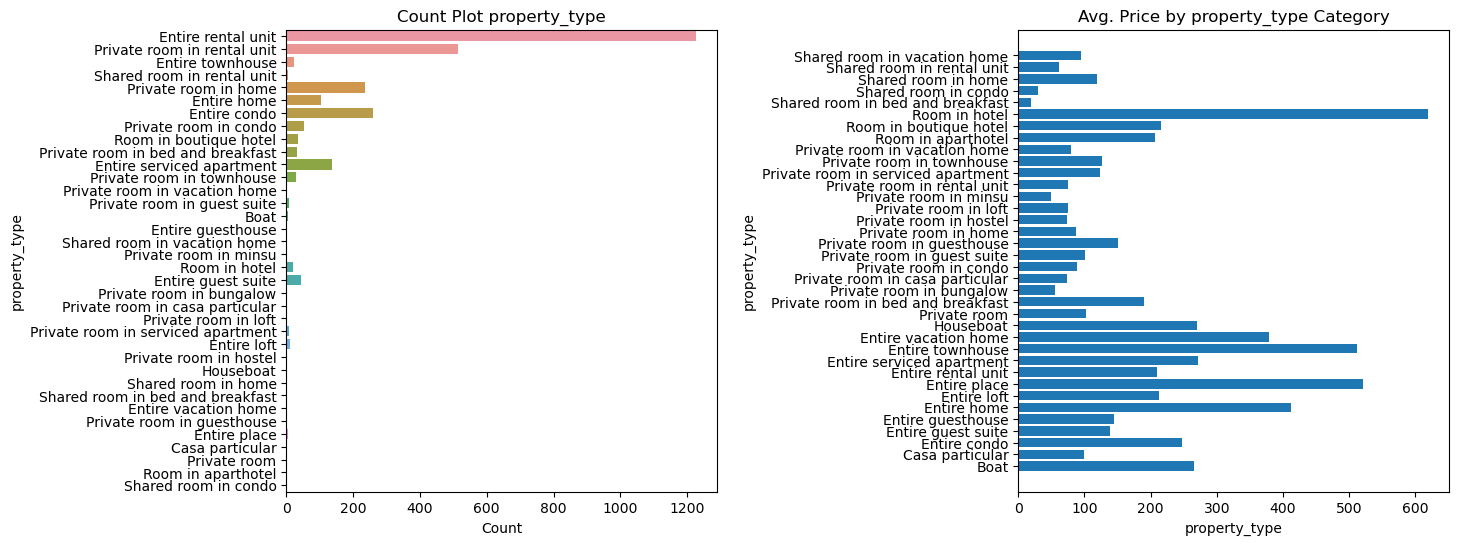

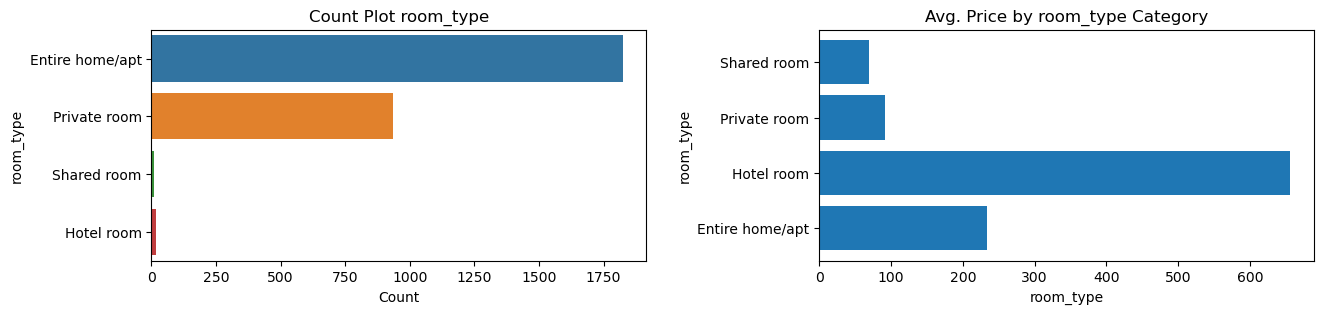

In [55]:
for i in [['bathrooms_text', .35, (15, 3)],
 ['has_availability', .1, (15, 3)],
 ['host_has_profile_pic', .1, (15, 3)],
 ['host_identity_verified', .1, (15, 3)],
 ['host_is_superhost', .1, (15, 3)],
 ['host_response_time', .4, (15, 3)],
 ['host_verifications', .6, (15, 3)],
 ['instant_bookable', .1, (15, 3)],
 ['neighbourhood_cleansed', .5, (15, 4)],
 ['property_type', .7, (15, 6)],
 ['room_type', .35, (15, 3)]]:
    hbar_plotter_price(lstn[i[0]], spc = i[1], size = i[2])

#### OBSERVATIONS:
* From the average price by bathroom type chart, 4 bath listings are the most expensive, however, 1 bath listings are the most common
* The vast majoity of listings:
    * Have hosts with profile pics whos identifites are verified
    * Have availability
    * Are not superhosts
* All of the above features may be so lop-sided that no correlation would be observed
* Most hosts respond within an hour, and those who respond within a few hours have the cheapest listings on average
* Most hosts are available via email and phone, but all major categories of availabilty have about the same average prices
* Not much of a correlation between instant bookability and price
* Some neighborhoods have listings which are certainly more expensive.  From personal experience as a Bay Stater (someone from Massachusetts), this checks out.
* There are only a few large categories of property type
* The average price by room type shows large variations, and there may be some correlation between these variables

In [56]:
# Make a copy dataframe with the columns above and the price for preliminary encoding
lstn_ohe = lstn[cat_cols].copy()
lstn_ohe['price'] = lstn.price.copy()

# One hot encode with get dummies and drop first for linear model
lstn_ohe = pd.get_dummies(lstn_ohe, drop_first=True)
lstn_ohe.shape

(2781, 96)

In [57]:
# Find correlations to price between all variables one hot encoded above
lstn_ohe.corr()['price'].sort_values(ascending=False)

price                                        1.000000
bathrooms_text_4 baths                       0.275243
bathrooms_text_2 baths                       0.254731
property_type_Entire home                    0.212717
property_type_Room in hotel                  0.171645
                                               ...   
bathrooms_text_0 shared baths               -0.134627
property_type_Private room in home          -0.147431
bathrooms_text_1 shared bath                -0.207068
property_type_Private room in rental unit   -0.258554
room_type_Private room                      -0.328703
Name: price, Length: 96, dtype: float64

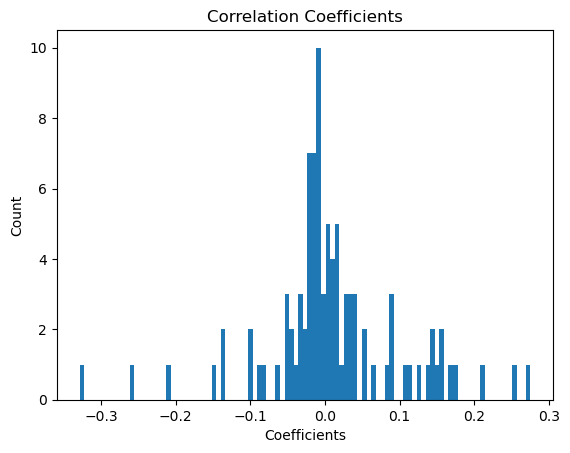

In [58]:
# View all correlations in a histogram.  Exclude price as that correlation is always 1
plt.hist(lstn_ohe.corr()['price'][1:-1].sort_values(ascending=False), bins = 99);
plt.title('Correlation Coefficients')
plt.xlabel('Coefficients')
plt.ylabel('Count');

# Remaining Features
The remaining features which have not yet been investigated are provided as follows, along with a brief plan to evaluate each of those features:
* amenities
    * These need to be separated out into the individual amenities, counted up, and one hot encoded
* description
    * This will require some manual examination and NLP techniques to attempt to find useful features
* host_about
    * This will require some manual examination and NLP techniques to attempt to find useful features
* name
    * This will require some manual examination and NLP techniques to attempt to find useful features
* neighborhood_overview
    * This will require some manual examination and NLP techniques to attempt to find useful features
    
    
## The features below were not able to be explored in this phase of the project and will be explored in subsequent iteration:
* host_location
    * This will need to be combined with host_neighbourhood and encoded accordingly
* host_neighbourhood
    * This will need to be combined with host_location and encoded accordingly
* license
    * This will require come NLP techniques to extract similar values

# Export Training Dataset in Current State
Some data have been corrected and that should be preserved into the next notebook.

Once all EDA has been complete, a single function will be createde to perform all processing steps to the datasets going forward.

In [59]:
# export the data to .csv
lstn.to_csv('../data/listings_train_2.csv', index=False)